## <FONT COLOR="Purple">*Lydia Messaoui*


***
## Projet « Modèle de Prévision du Pic d'Ozone avec R »
https://github.com/wikistat/Apprentissage/blob/master/Pic-ozone/Apprent-R-Ozone.ipynb
***

### Introduction

L'objectif, sur ces données, est d'améliorer la prévision déterministe (MOCAGE), calculée par les services de MétéoFrance,  de la concentration d'ozone dans certaines stations de prélèvement.  Il s'agit d'un problème dit d'*adaptation statistique* d'une prévision locale de modèles à trop grande échelle en s'aidant d'autres variables également gérées par MétéoFrance, mais à plus petite échelle (température, force du vent...). C'est une première façon de concevoir de l'l'*IA hybride* entre un modèle déterministe et un algorithme d'apprentissage automatique. Plus précisément, deux variables peuvent être prévues : soit la concentration quantitative d'ozone, soit le dépassement (qualitatif) d'un certain seuil fixé à 150 $\mu g$. Dans chaque cas, deux approches sont considérées : soit prévoir la *concentration quantitative* puis en déduire l'éventuel dépassement ou bien prévoir directement le *dépassement*. Dans le premier cas, il s'agit d'abord d'une *régression* tandis que dans le deuxième il s'agit d'un problème de *discrimination* à deux classes ou de régression logistique. 

La question posée est donc: quelles sont les meilleures méthodes et stratégies pour prévoir la concentration d'ozone du lendemain d'une part et l'occurrence d'un pic de pollution d'autre part.

On se propose de tester différentes méthodes : régression [logistique](http://wikistat.fr/pdf/st-m-app-rlogit.pdf), [analyse discriminante](http://wikistat.fr/pdf/st-m-app-add.pdf), [réseau de neurones](http://wikistat.fr/pdf/st-m-app-rn.pdf), [arbre de décision](http://wikistat.fr/pdf/st-m-app-cart.pdf), [agrégation d'arbres](http://wikistat.fr/pdf/st-m-app-agreg.pdf) (bagging, boosting, random forest), [SVM](http://wikistat.fr/pdf/st-m-app-svm.pdf).  L'objectif final, à ne pas perdre de vue, est la comparaison de ces méthodes afin de déterminer la plus efficace pour répondre au problème de prévision. Ceci passe par la mise en place d'un protocole très strict afin de s'assurer d'un minimum d'objectivité pour cette comparaison.

## Description des données Pic-Ozone:

Les données ont été extraites et mises en forme par le service concerné de Météo France. Elles sont décrites par les variables suivantes:


* **JOUR** Le type de jour ; férié (1) ou pas (0) ;
* **O3obs** La concentration d'ozone effectivement observée le lendemain à 17h locales correspondant souvent au maximum de pollution observée ;
* **MOCAGE** Prévision de cette pollution obtenue par un modèle déterministe de mécanique des fluides (équation de Navier et Stockes);
* **TEMPE** Température prévue par MétéoFrance pour le lendemain 17h ;
* **RMH2O** Rapport d'humidité ;
* **NO2** Concentration en dioxyde d'azote ;
* **NO** Concentration en monoxyde d'azote ;
* **STATION** Lieu de l'observation : Aix-en-Provence, Rambouillet, Munchhausen, Cadarache et Plan de Cuques ;
* **VentMOD** Force du vent ;
* **VentANG** Orientation du vent.


Ce sont des données "propres", sans trous, bien codées et de petites tailles. Elles présentent donc avant tout un caractère pédagogique car permettant de décliner puis comparer toutes les approches de régression et classification supervisée.

**Attention:** Même si les données sont de qualité, une étude exploratoire préalable est toujours nécessaire pour se familiariser avec les données et les préparer à la phase de modélisation.

###  Prise en charge des données

In [5]:
# Lecture des données
path="http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
ozone <- read.table(paste(path, "depSeuil.dat", sep = ""), sep = ",", header = TRUE)

# Vérification du contenu
summary(ozone)

      JOUR            O3obs           MOCAGE          TEMPE      
 Min.   :0.0000   Min.   : 19.0   Min.   : 46.4   Min.   :10.40  
 1st Qu.:0.0000   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20  
 Median :0.0000   Median :109.0   Median :125.6   Median :23.80  
 Mean   :0.3045   Mean   :115.4   Mean   :127.2   Mean   :23.88  
 3rd Qu.:1.0000   3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60  
 Max.   :1.0000   Max.   :319.0   Max.   :284.7   Max.   :38.00  
     RMH2O              NO2               NO           STATION         
 Min.   :0.00285   Min.   : 0.258   Min.   :0.0010   Length:1041       
 1st Qu.:0.00763   1st Qu.: 1.248   1st Qu.:0.2360   Class :character  
 Median :0.00985   Median : 2.109   Median :0.3880   Mode  :character  
 Mean   :0.01025   Mean   : 3.505   Mean   :0.6574                     
 3rd Qu.:0.01244   3rd Qu.: 4.062   3rd Qu.:0.7440                     
 Max.   :0.02753   Max.   :44.396   Max.   :9.4290                     
    VentMOD           VentANG     

In [6]:
# Changement du type des variables qualitatives en facteur
ozone[, "JOUR"] <- as.factor(ozone[, "JOUR"])
ozone[, "STATION"] <- as.factor(ozone[, "STATION"])

### 2. Exploration élémentaire

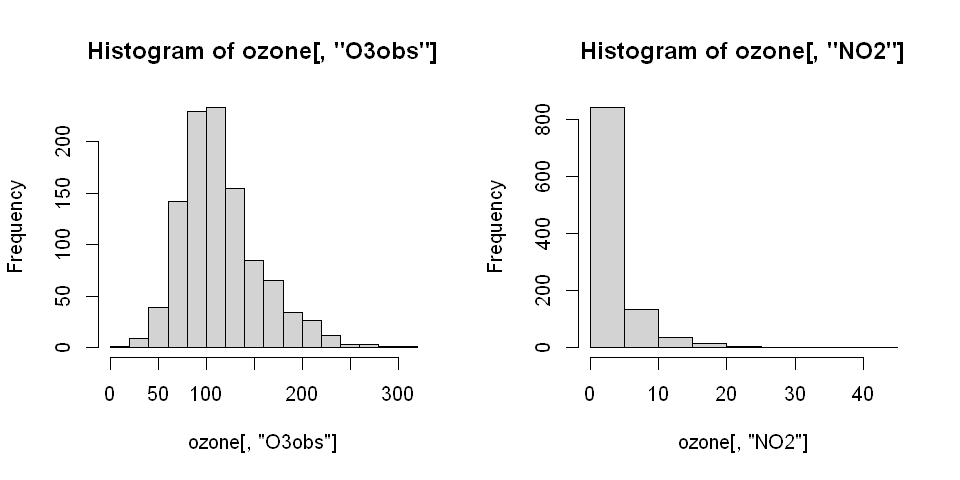

In [7]:
par(mfrow = c(1, 2))
options(repr.plot.width = 8, repr.plot.height = 4)
hist(ozone[, "O3obs"])
hist(ozone[, "NO2"])

***
**Remarquer le type des variables. Il est nécessaire d'en étudier la distribution. Noter la symétrie ou non de celles-ci.**

<font color='blue'> 
    
- Les variables sont des variables continues de type float.
    
- La distribution de la variable O3obs (concentration d'ozone) prend la forme d'une courbe en cloche, donc elle semble suivre une loi normale (modèle Gaussien). Elle est plutôt symétrique autour de la valeur x=100. 
  
- La variable NO2 (concentration en dioxyde d'azote) a une distribution non symètrique plus forte à gauche. Elle semble suivre une loi exponentielle.    
</font>
***

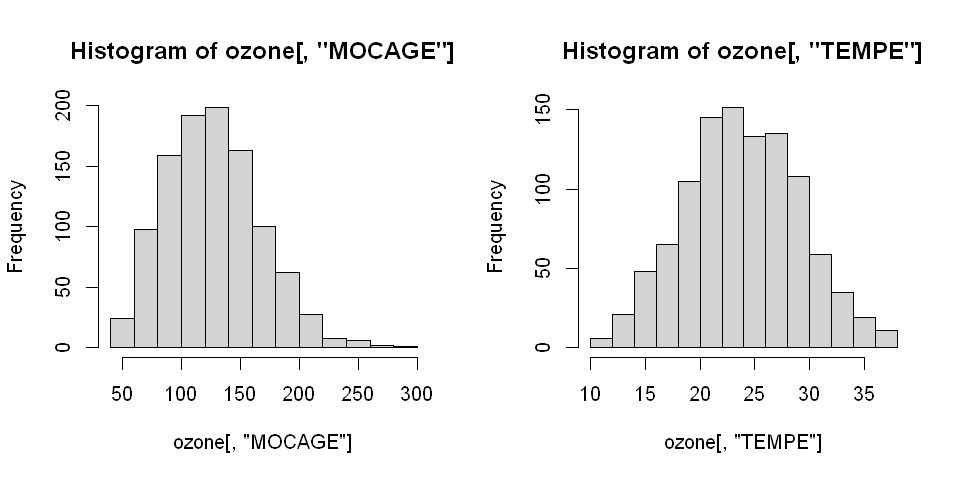

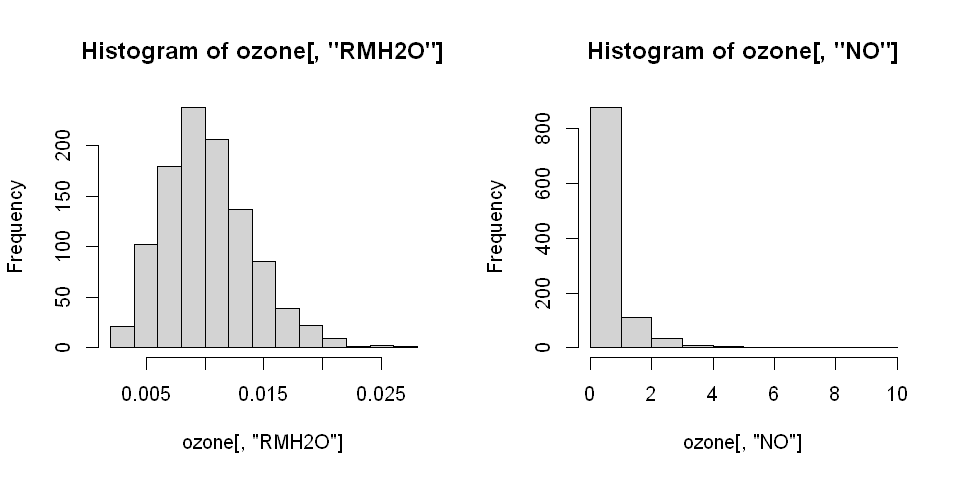

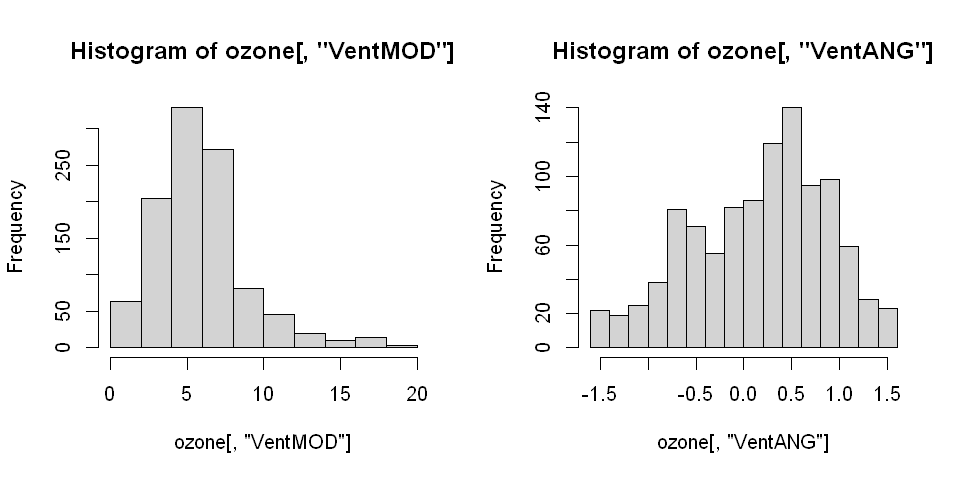

In [8]:
par(mfrow = c(1, 2))
# Même chose pour les autres variables
 hist(ozone[,"MOCAGE"]);hist(ozone[,"TEMPE"]);hist(ozone[,"RMH2O"])
#
hist(ozone[,"NO"]);hist(ozone[,"VentMOD"]);hist(ozone[,"VentANG"])

***
<font color='blue'>
    
- La variable TEMPE a une distribution qui semble suivre une loi normale.
- Les variables MOCAGE et RMH20 ont une distribution non symetrique trop forte à droite. On pourrait penser qu'elles suivent une loi exponentielle.
- Les variables NO et VentMOD et VentANG ont des distributions qui ne semblent pas suivre des lois normales. En effet, elles ont distribution non symetrique et uniformément distribuées autour de la moyenne.
</font>

***

Des transformations sont proposées pour rendre certaines distributions plus symétriques et  ainsi plus "gaussiennes". C'est nécessaire pour certaines méthodes à venir  de modélisation (linéaires),par pour toutes (arbres).

In [10]:
ozone[, "SRMH2O"] <- sqrt(ozone[, "RMH2O"])
ozone[, "LNO2"] <- log(ozone[, "NO2"])
ozone[, "LNO"] <- log(ozone[, "NO"])

Vérifier l'opportunité de ces transformations puis retirer les variables initiales et construire la variable "dépassement de seuil" pour obtenir le fichier qui sera effectivement utilisé.

In [11]:
ozone <- ozone[, c(1:4, 8:13)]
ozone[, "DepSeuil"] <- as.factor(ozone[, "O3obs"] > 150)
summary(ozone)

 JOUR        O3obs           MOCAGE          TEMPE       STATION  
 0:724   Min.   : 19.0   Min.   : 46.4   Min.   :10.40   Aix:199  
 1:317   1st Qu.: 87.0   1st Qu.: 97.5   1st Qu.:20.20   Als:222  
         Median :109.0   Median :125.6   Median :23.80   Cad:202  
         Mean   :115.4   Mean   :127.2   Mean   :23.88   Pla:208  
         3rd Qu.:135.0   3rd Qu.:153.6   3rd Qu.:27.60   Ram:210  
         Max.   :319.0   Max.   :284.7   Max.   :38.00            
    VentMOD           VentANG            SRMH2O             LNO2        
 Min.   : 0.1414   Min.   :-1.5708   Min.   :0.05339   Min.   :-1.3548  
 1st Qu.: 3.9623   1st Qu.:-0.3948   1st Qu.:0.08735   1st Qu.: 0.2215  
 Median : 5.5973   Median : 0.2783   Median :0.09925   Median : 0.7462  
 Mean   : 5.9072   Mean   : 0.1631   Mean   :0.09957   Mean   : 0.8440  
 3rd Qu.: 7.1063   3rd Qu.: 0.6926   3rd Qu.:0.11153   3rd Qu.: 1.4017  
 Max.   :19.8910   Max.   : 1.5708   Max.   :0.16592   Max.   : 3.7931  
      LNO           

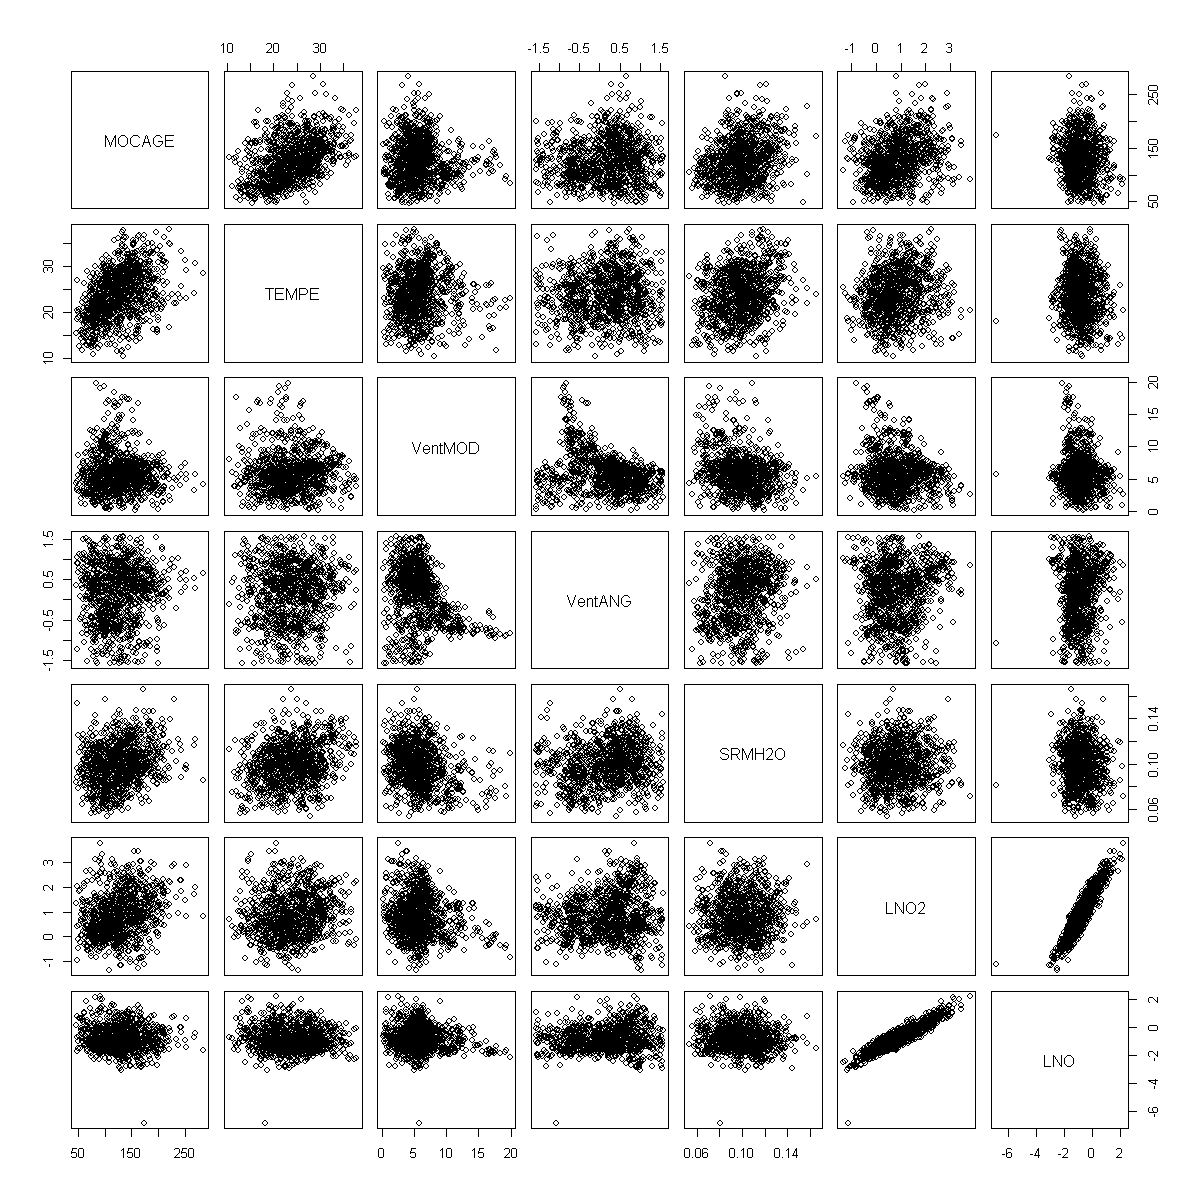

In [12]:
options(repr.plot.width = 10, repr.plot.height = 10)
pairs(ozone[, c(3, 4, 6:10)])

*** 
**Q** Que dire sur les relations des variables 2 à 2 ?
   
<font color='blue'>
Cette représentation graphique permet d'analyser la corrélation des variables 2 à 2. Les variables sont fortement corréléees si les point sont trés proches. Si les point sont éparpillés, les variables ne sont pas corrélées.
    
- les variables LNO2 et LN0 sont tés fortement corrélées, ce qui signifie qu'il y ai une redondance d'information à inclure ces deux variables dans un modèle.
    
- On observe aussi une corrélation entre les variables MOCAGE et TEMPE.
    
- les autres variables ne semblent pas être corrélés.

</font>
***

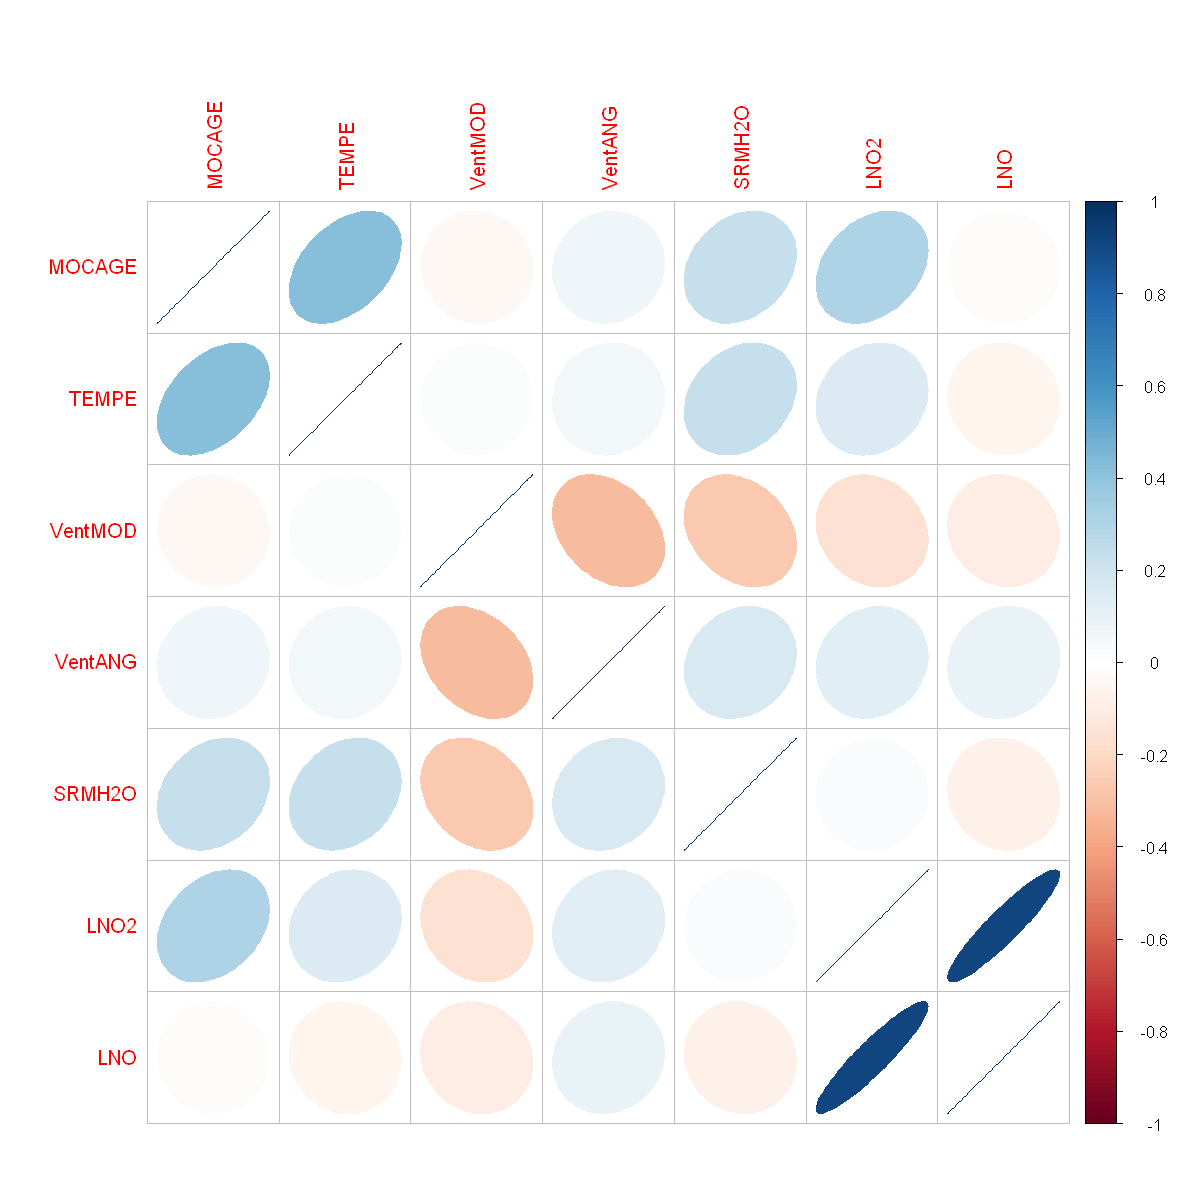

In [13]:
library(corrplot)
myData <- cor(ozone[, c(3, 4, 6:10)])
corrplot(myData, method = "ellipse")

***
**Q** Compléter en visualisant les corrélations avec la fonction 'corrplot' (package `corrplot`). Quelle est la limite de ce type de diagnostic numérique : quel type de corrélation est mesuré ?

<font color='blue'>
Le package "corrplot" permet de visualiser les corrélations entre les variables.
    
- On observe que les variables MOCAGE/TEMP et LNO/LNO2 sont positivement corrélées, ce qui confirme les observations dans la question précédente.
    
- On observe une faible corrélation positive entre les variables LNO2 et MOCAGE.
    
- On observe aussi que les variables VentANG et VentMOD ont une corrélation négative faible, ce qui ne s'observe pas vraiment sur le plot précédent car, peu de valeurs VentMOD superieurs à une certaine force du vent ont été présentées ce qui biaise la valeur de corrrelation. C'est un exemple de la limitation de ce type de diagnostic numérique.
</font>
***

##  ACP

Les commandes suivantes permettent de réaliser une analyse en composantes principales sur les seules variables quantitatives. Par ailleurs la variable à modéliser (O3obs, concentration observée) n'est pas utilisée.



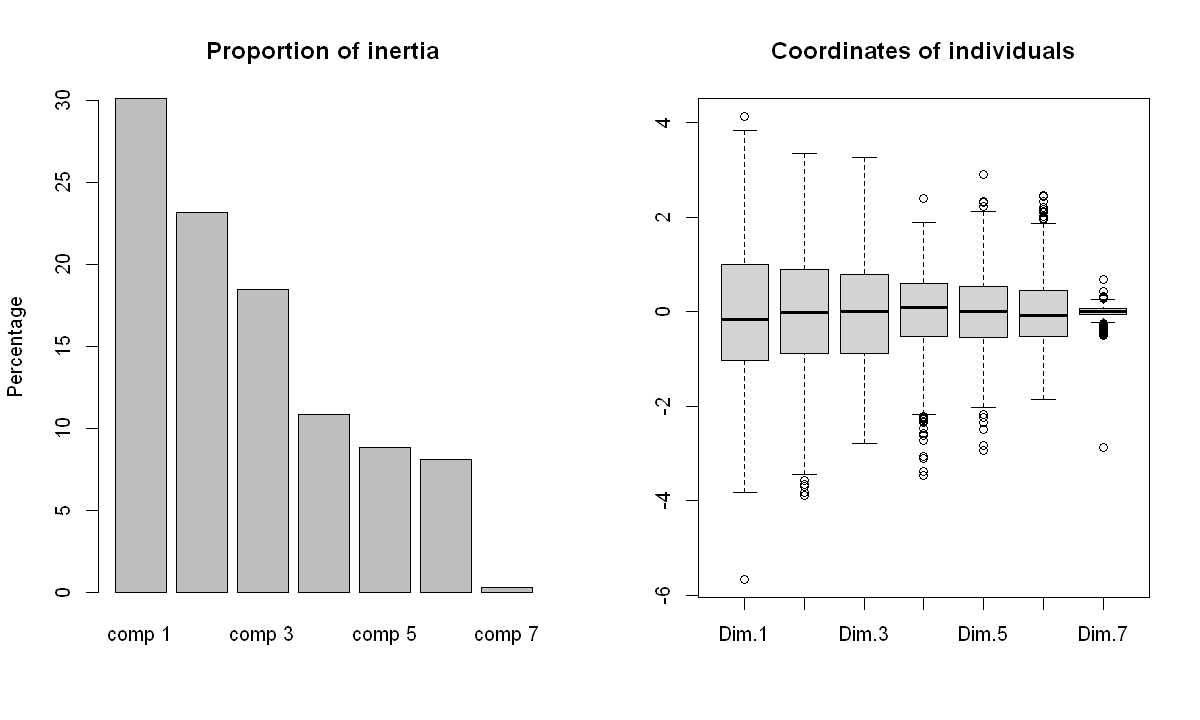

In [29]:
# ACP réduite
# Décroissance des valeurs propres
library(FactoMineR)
acp <- PCA(ozone[, c(11, 3:4, 6:10)], scale.unit = TRUE,
           graph = FALSE, quali.sup = 1, ncp = 7) #la variable "O3obs" n'est pas utilisée
options(repr.plot.width = 10, repr.plot.height = 6)
par(mfrow = c(1, 2))
barplot(acp$eig[, 2], ylab = "Percentage", main = "Proportion of inertia")
boxplot(acp$ind$coord, main = "Coordinates of individuals")

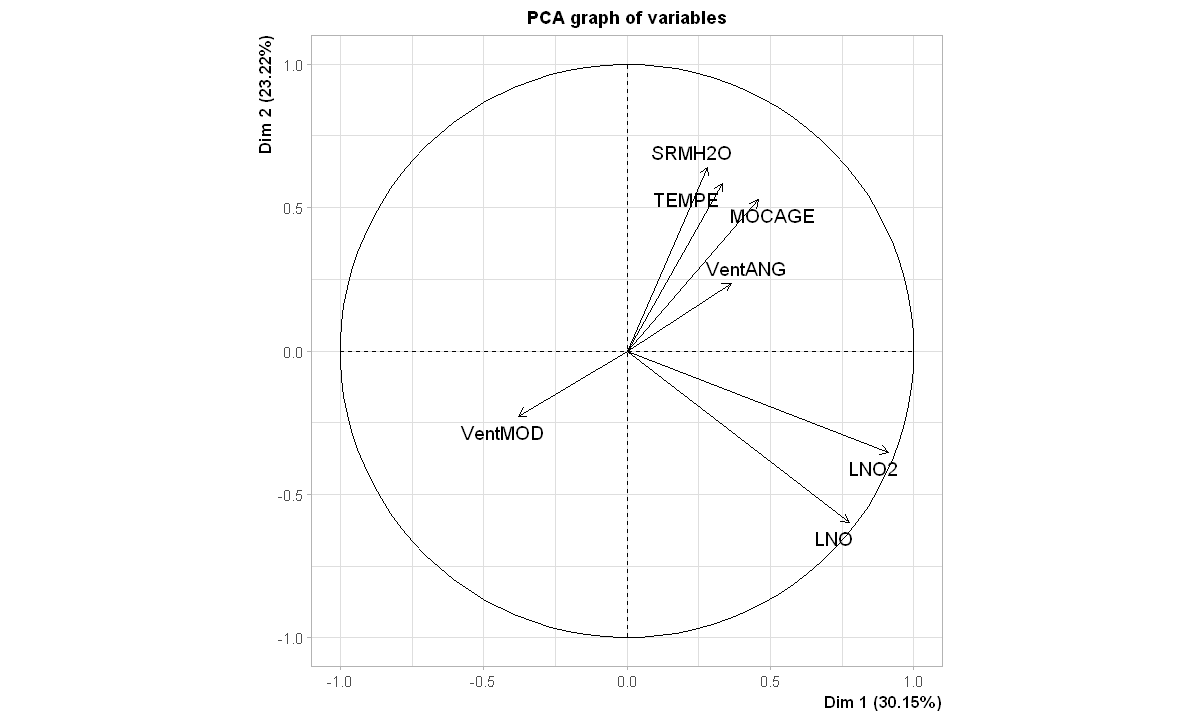

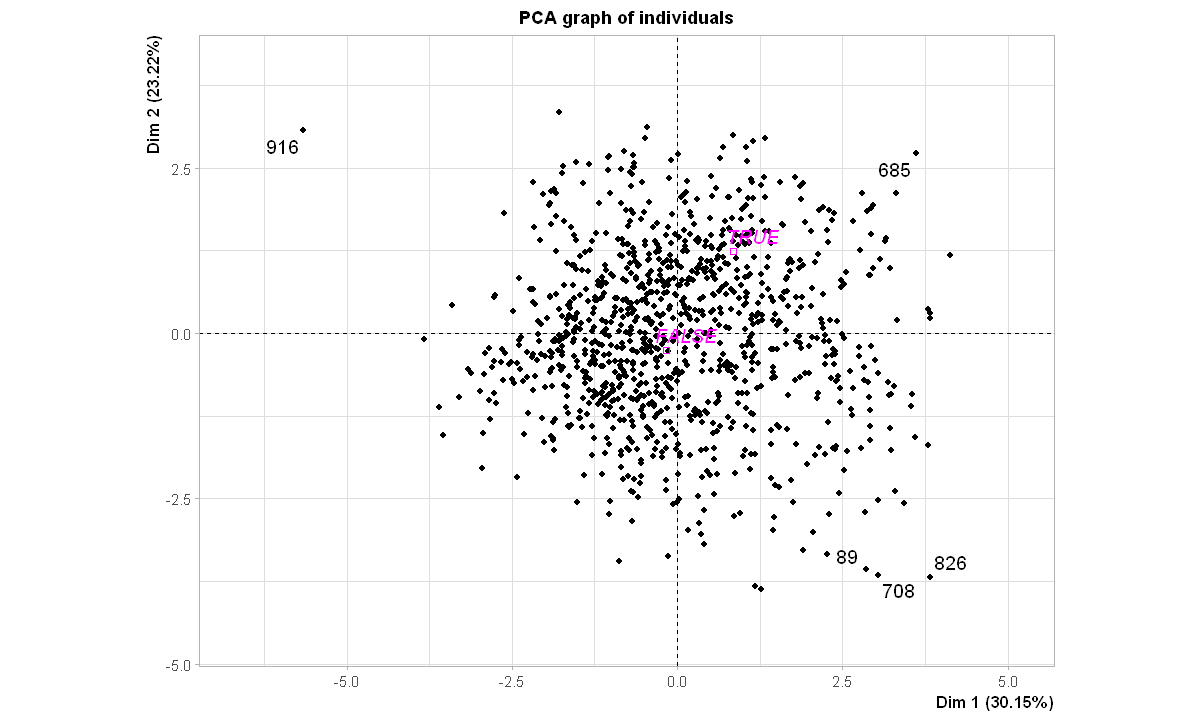

In [28]:
plot(acp, choix = "varcor")
plot(acp, choix = "ind", select = "contrib 5", unselect = 0)

***
**Q** Que sont ces graphiques?

<font color='blue'>
Ces graphiques representent l'application d'un algorithme de reduction de dimensions (PCA), qui réduit en deux dimensions les variables du jeu de données. Ainsi, il est plus simple de visualiser graphiquement les corrélations entre les variables.
    
- le premier graphique "PCA graph of variables" représente la corrélation entre les variables. Les variables présentées par des vecteurs étant dans le même sens et ayant des coefficients directeurs proches sont corrélées.
    
- le second graphique "PCA graph of individuals" représente la contribution de chaque variable à la definition de dimensions dans le PCA. Plus le point de la variable est éloigné de l'origine plus sa contribution est importante.
    </font>
    
**Q** Que dire du choix de la dimension, des valeurs atypiques?

<font color='blue'>
La dimension permettant de visualiser les résultats étant d'une valeur égale à deux, il est plus simple d'analyser des variables qui sont nombreuses et dont la comprehension et l'interpretation peuvent être complexes.
    
Les valeurs atypiques sont plus éloignées du centre.
</font>

**Q**  Que dire de la structure de corrélation des variables ? Est-elle intuitive ?

<font color='blue'>    
A partir de la representation par vecteurs des variables, on déduit que la structure de corrélation n'est pas intuitive. Les variables SRMH2O, TEMPE, MOCAGE et VentANG sont positivement corrélés entre elles, car elles sont présentées par des vecteurs ayant des angles proches et le même sens. La variable VentMOD est négativement corrélée avec eux car le vecteur est dans le sens inverse. Les variables LNO2 et LNO sont positivement corrélées entre elles mais pas avec les autres varaibles car il y a une difference remarquables dans les angles et le sens avec les autres variables.
   </font>

***

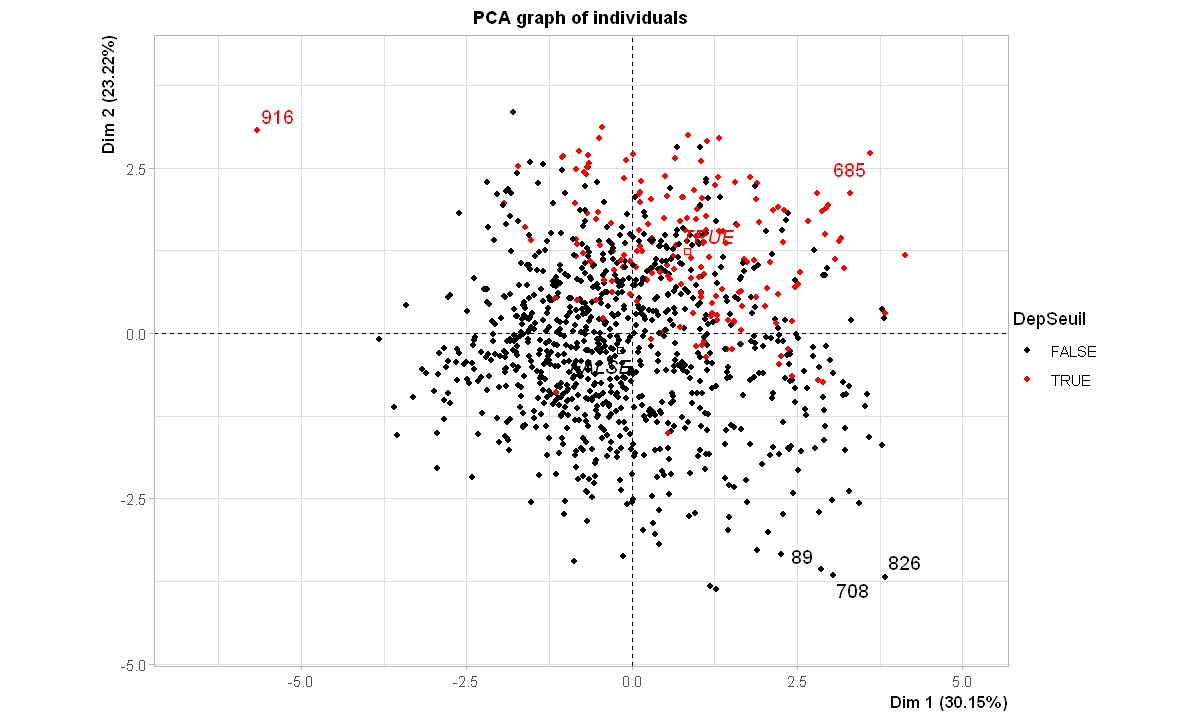

In [30]:
plot(acp, choix = "ind", habillage = 1,
     select = "contrib 5", unselect = 0)

L'objectif est donc de définir une surface séparant les deux classes.

***
**Q** Une discrimination linéaire (hyperplan) semble-t-elle possible? 

<font color='blue'>
Une discrimination linéaire ne semple pas possible car les classes sont confondues et il n'y a pas une séparation linéaire des deux classes.</font>

Ce n'est pas utile ici mais une classification non supervisée est facile à obtenir. Par exemple en 2 classes, par l'algorithme k-means. Donne t-elle la même information ?

</font>
<font color='blue'>
L'application de l'algorithme k-means permet de séparer de façon plus claire les données en 2 classes en considérant toutes les variable.</font>
</font>


***

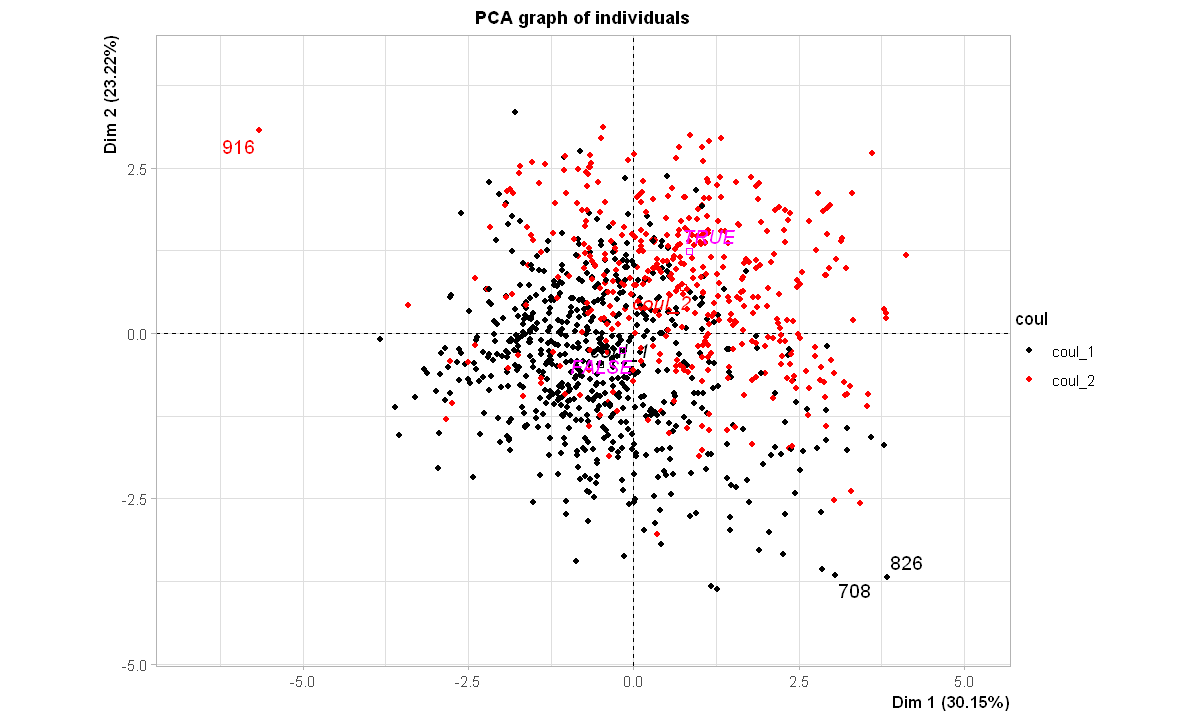

In [33]:
km.ozone <- kmeans(ozone[, c(3:4, 6:10)], centers = 2)
# Représentation dans les coordonnées de l'acp
acp2 <- PCA(cbind(coul = as.factor(km.ozone$cluster),
          ozone[, c(11, 3:4, 6:10)]), scale.unit = TRUE,
          graph = FALSE, quali.sup = 1:2, ncp = 7)
plot(acp2, choix = "ind", habillage = "coul",
     select = "contrib 3", unselect = 0)







## Protocole de comparaison
### Stratégie

La recherche d'une meilleure méthode de prévision suit le protocole suivant.
1) Etape descriptive préliminaire uni et multidimensionnelle visant à repérer les incohérences, les variables non significatives ou de distribution exotique, les individus non concernés ou atypiques... et à étudier les structures des données. Ce peut être aussi la longue étape de construction de variables, attributs ou features spécifiques des données.

2) Procéder à un tirage aléatoire d'un échantillon test qui ne sera utilisé que lors de la dernière étape de comparaison des méthodes.

3) La partie restante est l'échantillon d'apprentissage pour l'estimation des paramètres des modèles.
4) Pour chacune des méthodes, optimiser la complexité des modèles en minimisant une estimation "sans biais" de l'erreur de prévision, par exemple par validation croisée:
* Variables et interactions à prendre en compte dans la régression linéaire ou logistique;
* variables et méthode pour l'analyse discriminante;
* nombre de feuilles dans l'arbre de régression ou de classification;
* architecture (nombre de neurones, pénalisation) du perceptron;
* algorithme d'agrégation,
* noyau et pénalisation des SVMs.

5) Comparaison des qualités de prévision sur la base du taux de mal classés pour le seul échantillon test qui est resté à l'écart de tout effort ou "acharnement" pour l'optimisation des modèles.

### Remarques
En cas d'échantillon relativement "petit" il est recommandé d'itérer la procédure de découpage apprentissage / test, afin de réduire la variance (moyenne) des estimations des erreurs de prévision.

***
**Q** Commenta appelle-t-on cette procédure spécifique de validation croisée?

<font color='blue'>
    - Validation croisée Monte Carlo
</font>

*** 

**Attention:** ne pas "tricher" en modifiant le modèle obtenu lors de l'étape précédente afin d'améliorer le résultat sur l'échantillon test!

Le critère utilisé dépend du problème : erreur quadratique, taux de mauvais classement, entropie, AUC (aire sous la courbe ROC), indice de Pierce, log loss function...

### Extraction des échantillons

Les commandes ci-dessous réalisent l'extraction du sous-ensemble des données d'apprentissage et de test.


Utiliser trois chiffres au hasard, et remplacer "111" ci-dessous, comme initialisation du générateur de nombres aléatoires. Attention, chaque participant tire un échantillon différent ; il est donc "normal" de ne pas obtenir les mêmes modèles, les mêmes résultats.

In [34]:
set.seed(111) # initialisation du générateur
# Extraction des échantillons
test.ratio <- .2   # part de l'échantillon test
npop <- nrow(ozone) # nombre de lignes dans les données
nvar <- ncol(ozone) # nombre de colonnes
# taille de l'échantillon test
ntest <- ceiling(npop * test.ratio) 
# indices de l'échantillon test
testi <- sample(1:npop, ntest)
# indices de l'échantillon d'apprentissage
appri <- setdiff(1:npop, testi) 

Construction des échantillons pour la régression: prévision de la concentration en ozone.

In [35]:
# construction de l'échantillon d'apprentissage
datappr <- ozone[appri, -11] 
# construction de l'échantillon test
datestr <- ozone[testi, -11] 
summary(datappr) # vérification

 JOUR        O3obs           MOCAGE          TEMPE       STATION  
 0:581   Min.   : 19.0   Min.   : 46.4   Min.   :10.40   Aix:158  
 1:251   1st Qu.: 88.0   1st Qu.: 98.0   1st Qu.:20.27   Als:179  
         Median :110.0   Median :125.9   Median :23.90   Cad:165  
         Mean   :115.8   Mean   :127.7   Mean   :23.94   Pla:171  
         3rd Qu.:135.0   3rd Qu.:154.9   3rd Qu.:27.60   Ram:159  
         Max.   :319.0   Max.   :268.6   Max.   :38.00            
    VentMOD           VentANG            SRMH2O             LNO2        
 Min.   : 0.1414   Min.   :-1.5708   Min.   :0.05339   Min.   :-1.3548  
 1st Qu.: 3.9825   1st Qu.:-0.3940   1st Qu.:0.08813   1st Qu.: 0.2042  
 Median : 5.5938   Median : 0.3019   Median :0.09932   Median : 0.7405  
 Mean   : 5.9413   Mean   : 0.1687   Mean   :0.09967   Mean   : 0.8458  
 3rd Qu.: 7.1694   3rd Qu.: 0.6875   3rd Qu.:0.11155   3rd Qu.: 1.4301  
 Max.   :19.8910   Max.   : 1.5708   Max.   :0.16592   Max.   : 3.4377  
      LNO         
 

Construction des échantillons pour la discrimination: prévision de dépassement.

In [40]:
# construction de l'échantillon d'apprentissage
datappq <- ozone[appri,-2]
# construction de l'échantillon test 
datestq <- ozone[testi,-2] 
summary(datappq) # vérification

 JOUR        MOCAGE          TEMPE       STATION      VentMOD       
 0:581   Min.   : 46.4   Min.   :10.40   Aix:158   Min.   : 0.1414  
 1:251   1st Qu.: 98.0   1st Qu.:20.27   Als:179   1st Qu.: 3.9825  
         Median :125.9   Median :23.90   Cad:165   Median : 5.5938  
         Mean   :127.7   Mean   :23.94   Pla:171   Mean   : 5.9413  
         3rd Qu.:154.9   3rd Qu.:27.60   Ram:159   3rd Qu.: 7.1694  
         Max.   :268.6   Max.   :38.00             Max.   :19.8910  
    VentANG            SRMH2O             LNO2              LNO         
 Min.   :-1.5708   Min.   :0.05339   Min.   :-1.3548   Min.   :-6.9078  
 1st Qu.:-0.3940   1st Qu.:0.08813   1st Qu.: 0.2042   1st Qu.:-1.4610  
 Median : 0.3019   Median :0.09932   Median : 0.7405   Median :-0.9455  
 Mean   : 0.1687   Mean   :0.09967   Mean   : 0.8458   Mean   :-0.8418  
 3rd Qu.: 0.6875   3rd Qu.:0.11155   3rd Qu.: 1.4301   3rd Qu.:-0.2884  
 Max.   : 1.5708   Max.   :0.16592   Max.   : 3.4377   Max.   : 2.1416  
  DepS

## Partie 2

## Prévision par modèle gaussien

Le premier modèle à tester est un simple modèle de régression linéaire mais, comme certaines variables sont qualitatives, il s'agit d'une analyse de covariance. D'autre part, on s'intéresse à savoir si des interactions sont à prendre en compte. Le modèle devient alors polynomial d'ordre 2 ou quadratique.

### Modèle linéaire

Le modèle de régression linéaire simple intégre des variables qualitatives; c'est dans ce cas une *analyse de covariance*  estimée par la fonction `aov` mieux adaptée à ce modèle.

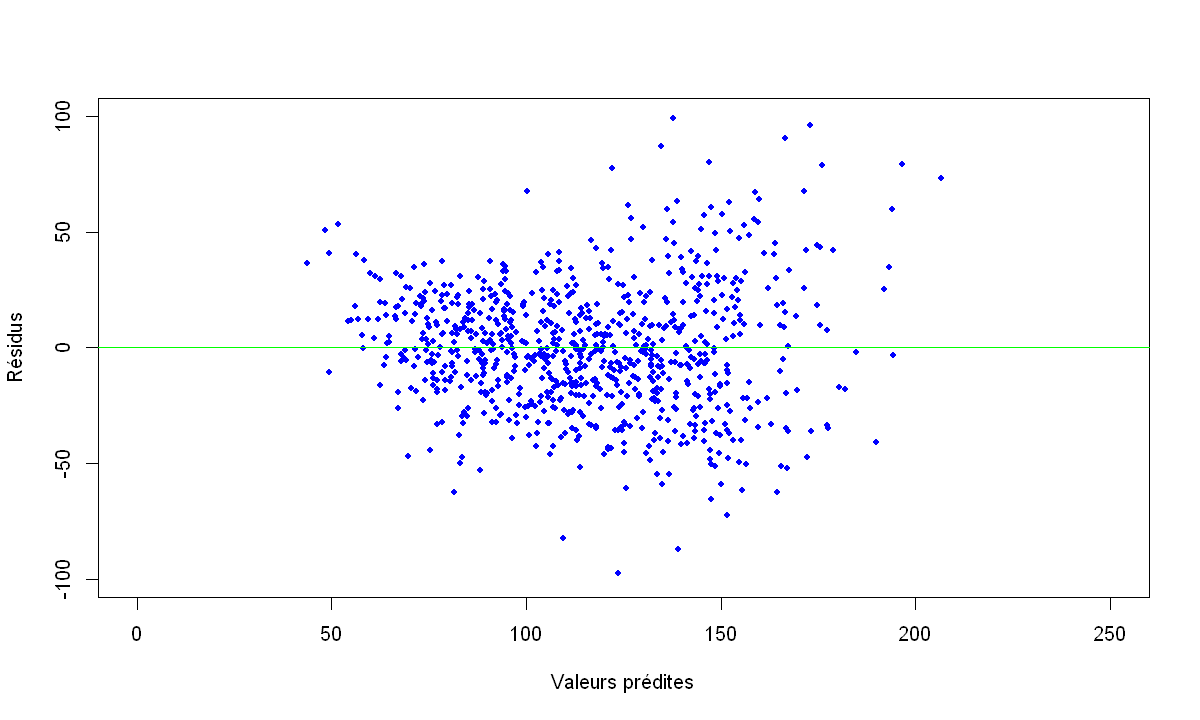

In [43]:
# estimation du modèle sans interaction
reg.lm <- aov(O3obs ~ . , data = datappr)
# Extraction des résidus et des valeurs ajustées de ce modèle
res.lm <- reg.lm$residuals
fit.lm <- reg.lm$fitted.values
# graphe des résidus. 
# Définition d'une fonction pour un graphe coloré 
# et des échelles fixes sur les axes
plot.res <- function(x,y,titre="titre")
{
plot(x, y, col = "blue", xlim = c(0, 250), ylim = c(-100, 100),
ylab = "Résidus", xlab = "Valeurs prédites", main = titre, pch = 20)
# points(x2, y, col="red")
abline(h = 0, col = "green")
}
plot.res(fit.lm,res.lm,"")

In [44]:
reg.lm

Call:
   aov(formula = O3obs ~ ., data = datappr)

Terms:
                    JOUR   MOCAGE    TEMPE  STATION  VentMOD  VentANG   SRMH2O
Sum of Squares     106.4 470173.0 225426.8  10162.6  13846.3  10087.5    273.3
Deg. of Freedom        1        1        1        4        1        1        1
                    LNO2      LNO Residuals
Sum of Squares    3337.3   9005.8  651913.0
Deg. of Freedom        1        1       819

Residual standard error: 28.21323
Estimated effects may be unbalanced

***
**Q** Que dire de la distribution de ces résidus? 

<font color='blue'>
- Les résidus sont distribuées entre 50 et 200 d'une manière qui n'est pas uniforme (la variance est pas constante) et pas centrée autour de 0.</font>

**Q** La forme du nuage renseigne sur les hypothèses de linéarité du modèle et d'homoscédasticité. Que dire de la validité de ce modèle?

<font color='blue'>
    
Le modèle doit suivre une loi normale $N(0,sigma^2)$ de laquelle découle certaines hypothèses non validés dans ce cas. On en conclut qu'il n'est pas valide.
    
- la forme du nuage des résidus montre une forte hétéroscédasticité (variance), cela signifie que la variance des résidus et donc des prévisions croît avec la valeur donc la qualité de la prévision se dégrade pour les concentrations élevées.
</font>

***
Apprécier néanmoins sa significativité par la commande suivante.

In [45]:
summary(reg.lm)

             Df Sum Sq Mean Sq F value   Pr(>F)    
JOUR          1    106     106   0.134 0.714791    
MOCAGE        1 470173  470173 590.680  < 2e-16 ***
TEMPE         1 225427  225427 283.204  < 2e-16 ***
STATION       4  10163    2541   3.192 0.012926 *  
VentMOD       1  13846   13846  17.395 3.36e-05 ***
VentANG       1  10088   10088  12.673 0.000392 ***
SRMH2O        1    273     273   0.343 0.558101    
LNO2          1   3337    3337   4.193 0.040918 *  
LNO           1   9006    9006  11.314 0.000805 ***
Residuals   819 651913     796                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

***
**Q** Ce premier modèle est comparé avec celui de la seule prévision déterministe MOCAGE. Qu'en conclure?

<font color='blue'>
    
Les graphiques témoignent de la mauvaise qualité de ce modèle :
    
- les résidus ne sont pas répartis de façon symétrique
    
- La forme du nuage des résidus montre une forte hétéroscédasticité, cela signifie que la variance des résidus et donc des prévisions croît avec la valeur donc la qualité de la prévision se dégrade pour les concentrations élevées 
    
- Mais le modèle quadratique (figure: linéaire, MOCAGE seul) fournit une forme plus "linéaire" (que les graphiques au-dessus) des résidus mais l’hétéroscédasticité reste présente

</font>

***

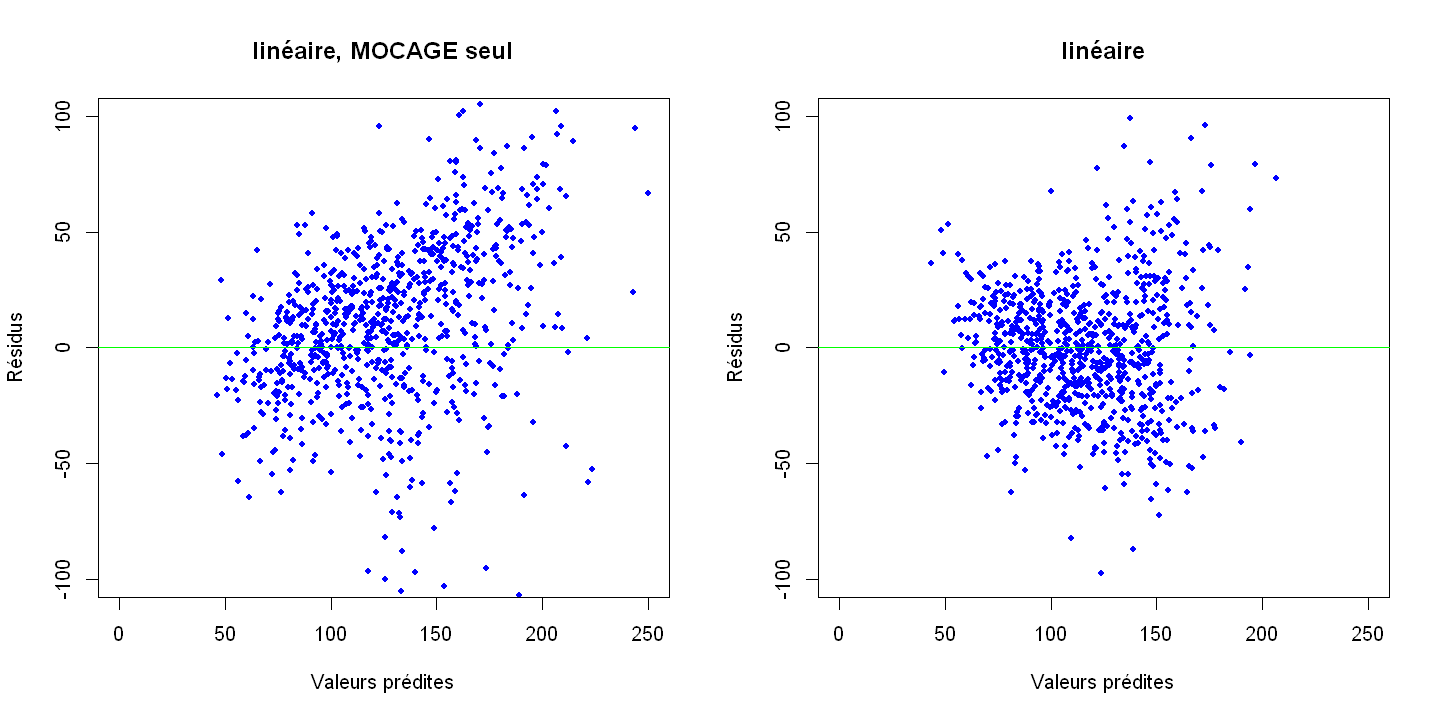

In [46]:
# Graphe des résidus du modèle déterministe MOCAGE
options(repr.plot.width = 12, repr.plot.height = 6)
par(mfrow = c(1, 2))
plot.res(datappr[, "MOCAGE"],
         datappr[, "MOCAGE"] - datappr[, "O3obs"], "linéaire, MOCAGE seul")
plot.res(fit.lm, res.lm, "linéaire")
par(mfrow = c(1, 1))

**Sélection de variable par régularisation L1 (LASSO)**

In [49]:
install.packages("glmnet")

Warning message:
"le package 'glmnet' a été compilé avec la version R 4.1.3"
Le chargement a nécessité le package : Matrix

Loaded glmnet 4.1-6



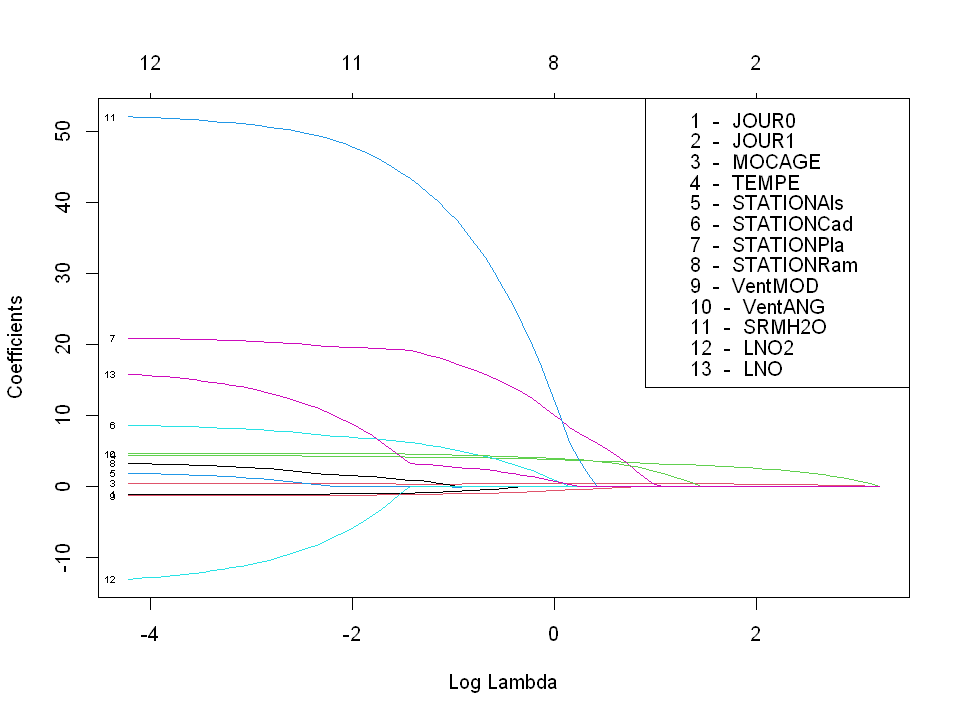

In [50]:
library(glmnet)
# avec des variables quantitatives seulement
reg.lasso.quanti <- glmnet(y = datappr[, 2],
                           x = as.matrix(datappr[, -c(1, 2, 5)]))
# avec toutes les variables, créer d'abord la matrice d'expériences 
# avec 'model.matrix' (penser à retirer l'intercept du modèle)
x.mat <- model.matrix(O3obs ~ . - 1, data = datappr)
reg.lasso <- glmnet(y = datappr$O3obs, x = x.mat)
options(repr.plot.width = 8, repr.plot.height = 6)
plot(reg.lasso, xvar = "lambda", label = TRUE)
legend("topright", 
       legend = paste(1:ncol(x.mat), " - ", colnames(x.mat)))

***
**Q** Que fait la commande model.matrix ? Comment sont gérées les variables catégorielles ?

<font color='blue'>
La commande model.matrix crée une matrice de conception (ou de design). C'est une matrice de taille $(N*P)$ avec N le nombre d'observations et P le nombre de variables. On observe que dans le code, la création de la matrice de design se fait en supprimant la colonne de l'intercept (colonne de 1). Les variables catégorielles sont contraintes à des facteurs qu'on peut developper en un ensemble de variables fictives (en fonction des contrastes).</font>

**Q** Que représentent les courbes ci-dessus, appelées "chemins de régularisation"?

<font color='blue'>
Les courbes, appelées "chemins de régularisation" représentent la valeur du coefficient estimé associé à la variable pour différentes valeurs de la pénalité (lambda i) appliquée par lasso : $log(lambda)$. Nous avons les logarithmes des lambda i en abscisse de notre graphique ils varient entre log(-4) et log(3). Une règle empirique consiste à choisir la valeur de lambda à partir de laquelle les coefficients commencent « à se stabiliser ».</font>


***

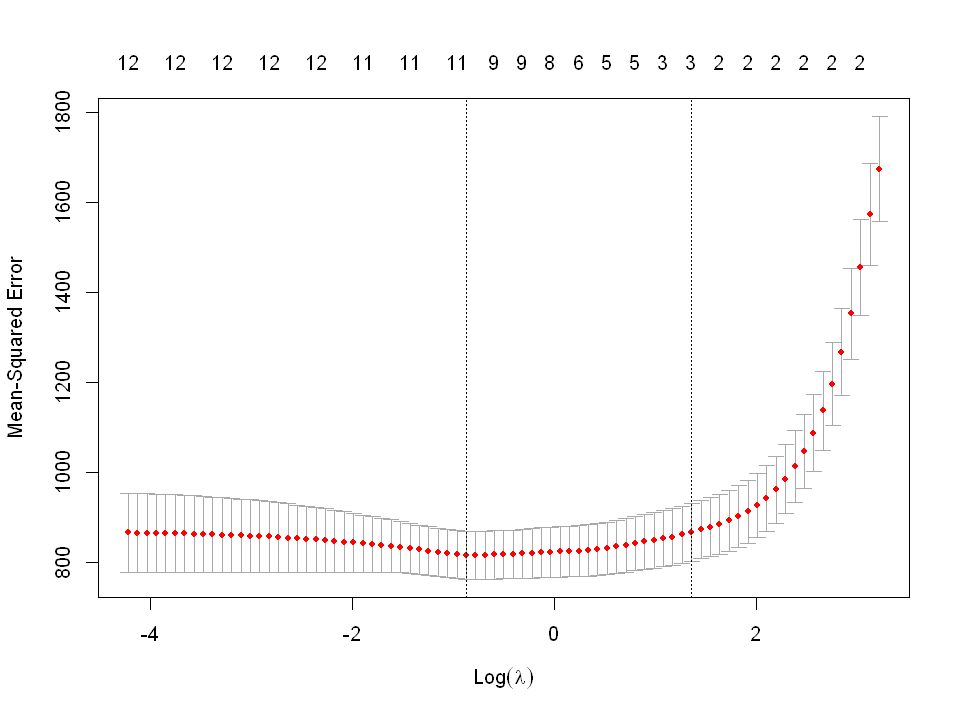

In [51]:
# choix du paramètre de régularisation par validation croisée
reg.lasso.cv <- cv.glmnet(y = datappr[, 2], x = x.mat)
plot(reg.lasso.cv)

***
<font color='blue'>Avec la cross validation, on essaye de trouver la valeur de $log(lambda)$ qui minimise l'erreur quadratique.</font>

**Q** Que représente la courbe rouge ? Et la bande qui est autour ? 
<font color='blue'>
La fonction glmnet effectue une validation croisée et produit un graphique qui permet de mettre en relation les valeurs de log(lambda) avec l'erreur quadratique. La courbe rouge représente l'erreur quadratique moyenne en fonction du log(lambda). La bande qui est autour représente l'intervalle de confiance.</font>

**Q** Comment sont obtenues les valeurs de log(lambda) correspondant aux lignes verticales en pointillé ?

<font color='blue'>
Elles correspondent à la plus grande valeur lambda tel que MSE < min(MSE) + écart_type[min(SE)].
                                                                         
En effet, un seuil de cette valeur est posé au préalable. L'objectif étant d'avoir une valeur la plus élevée possible sans trop influer sur l'erreur quadratique.                                                                         
                                                     
</font>


***

In [54]:
# valeur estimée
paste("CV estimate of lambda :", round(reg.lasso.cv$lambda.1se, 3))
# modèle correspondant
coef(reg.lasso.cv, s = "lambda.1se")

[1] "CV estimate of lambda : 3.896"

14 x 1 sparse Matrix of class "dgCMatrix"
                   s1
(Intercept) 1.1658431
JOUR0       .        
JOUR1       .        
MOCAGE      0.3370194
TEMPE       2.9855716
STATIONAls  .        
STATIONCad  .        
STATIONPla  .        
STATIONRam  .        
VentMOD     .        
VentANG     0.4939697
SRMH2O      .        
LNO2        .        
LNO         .        

***
**Q** Combien restent-ils de coefficients non nuls. Vérifier sur les chemins de régularisation.

<font color='blue'>Pour cette valeur de lambda, il reste quatre coefficients non nuls (MOCAGE, TEMPE et VentANG et Intercept y compris). On vérifie sur les chemins de régularisation qui montrent bien que ce sont les dernières valeurs à se stabiliser (l'intercept n'était pas inclut dans les variables présentées dans la matrice de conception).</font>
    
**Q** Même question en choisissant l'autre valeur de lambda retenue par glmnet, i.e. "reg.lasso.cv$lambda.min"

<font color='blue'>
On observe qu'il reste maintenant 11 variables (intercept y compris), ce que est justifié par le fait que plus $lambda$ est petit, moins les variables sont "pénalisées".
</font>

***

In [58]:
# valeur estimée
paste("CV estimate of lambda :", round(reg.lasso.cv$lambda.min, 3))
# modèle correspondant
coef(reg.lasso.cv, s = "lambda.min")

[1] "CV estimate of lambda : 0.418"

14 x 1 sparse Matrix of class "dgCMatrix"
                      s1
(Intercept) -18.02986736
JOUR0        -0.67101204
JOUR1         .         
MOCAGE        0.29912279
TEMPE         4.00531665
STATIONAls   -0.09333231
STATIONCad    4.71348395
STATIONPla   16.73098026
STATIONRam    .         
VentMOD      -1.06568750
VentANG       4.32796699
SRMH2O       35.78513984
LNO2          .         
LNO           2.55034443

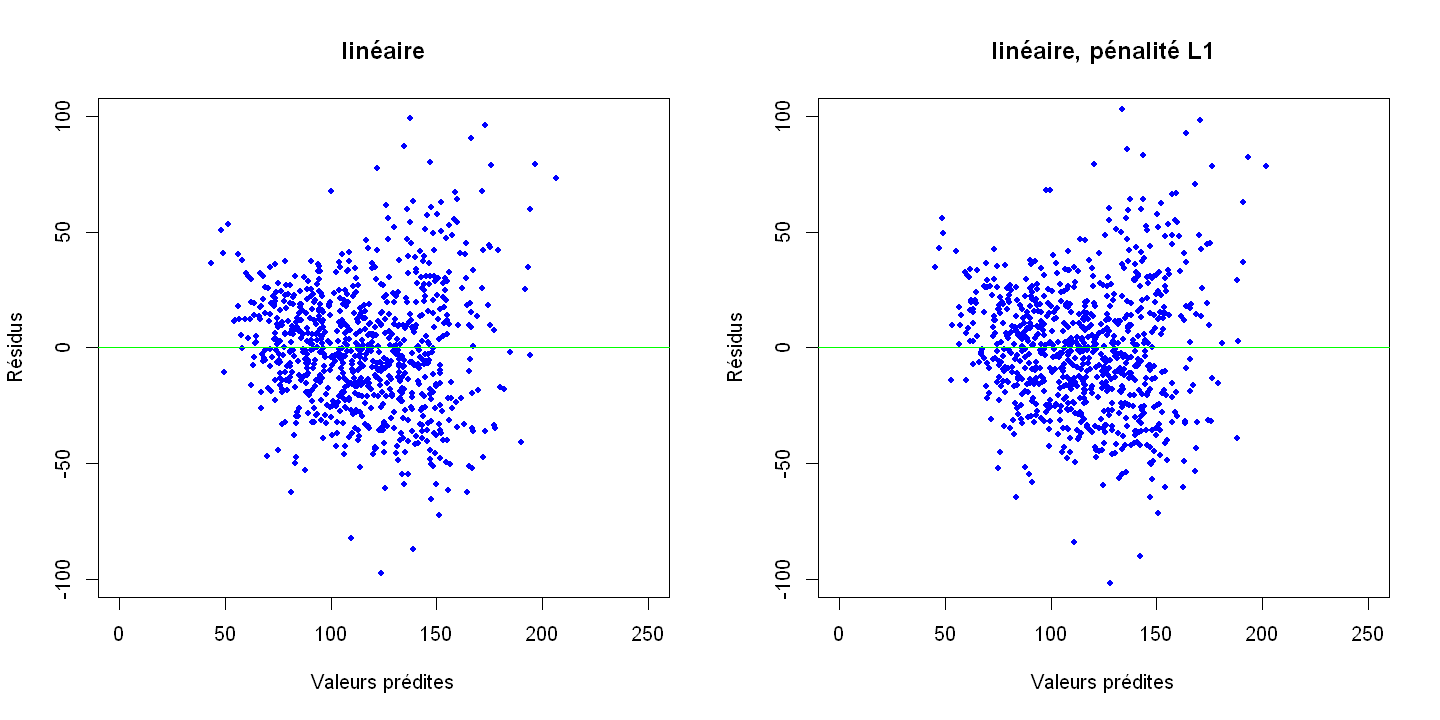

In [57]:
# Extraction des valeurs ajustées et des résidus
fit.lasso <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat)
res.lasso <- datappr$O3obs - fit.lasso
# Graphe des résidus
options(repr.plot.width = 12, repr.plot.height = 6)
par(mfrow = c(1, 2))
plot.res(fit.lm, res.lm, "linéaire")
plot.res(fit.lasso, res.lasso, "linéaire, pénalité L1")

*** 
**Q** Commenter. 

<font color='blue'>
    
On observe que les modèles sont très similaires alors que des variables ont été "supprimées". On conclut qu'enlever des variales n'a pas remédié aux problèmes d'hétéroscédasticité et de non centrage autour de 0.</font>
 </font> 
 
**Q** Calculer le critère MSE (moyenne des carrés des résidus) pour les deux modèles. Pourquoi celui obtenu par LASSO est-il moins bon ? Quel critère LASSO minimise t-il ?

<font color='blue'>
    
- RMSE pour la régression linéaire = 27.99
    
- RMSE pour la régression linéaire avec régularisation lasso = 28.17
    
- Le MSE de LASSO est plus grand parce qu'il y a moins de variables. En réalité, il suffit d'ajouter des variables pour diminuer le MSE.
    
- LASSO minimise le MSE
    
 </font> 

***

In [59]:
sqrt(mean(res.lm^2)) ## RMSE modèle linéaire

[1] 27.99195

In [60]:
sqrt(mean(res.lasso^2)) ## RMSE modèle linéaire

[1] 28.17064

## Modèle quadratique

L'étude suivante met en oeuvre toutes les interactions d'ordre 2 entre les variables. Il s'agit donc d'un modèle de régression quadratique. Il est estimé avec la fonction glm qui permet une sélection automatique de modèle. La méthode descendante est utilisée mais celle pas-à-pas pourrait également l'être. Ce type de procédure n'est pas implémentée en python.

#### Sélection de variables par critère AIC

Sélection descendante: à chaque étape, chaque modèle est comparé à tous les sous-modèles possibles obtenus par suppression d'une des interactions ou une des variables, à condition qu'elle ne soit pas présente dans une interaction. La variable sélectionnée et supprimée est celle qui fait décroîre le critère considéré : AIC ou Akaïke Information Criterion.

*** 
**Q** Quel autre critère, équivalent à AIC dans le cas gaussien et de variance résiduelle connue, est utilisée en régression linéaire? 

<font color='blue'>
    
C'est le BIC Bayesian Information Criterieon : penalise encore plus le nombre de paramètres.
</font>



***

In [64]:
# Estimation du modèle de toute interaction d'ordre 2
reg.glm <- glm(O3obs ~ .^2, data = datappr)
# Recherche du meilleur modèle au sens 
# du critère d'Akaïke par méthode descendante
reg.glm.step <- step(reg.glm, direction = "backward")

Start:  AIC=7783.44
O3obs ~ (JOUR + MOCAGE + TEMPE + STATION + VentMOD + VentANG + 
    SRMH2O + LNO2 + LNO)^2

                  Df Deviance    AIC
- JOUR:STATION     4   471877 7776.5
- STATION:VentANG  4   471970 7776.7
- JOUR:TEMPE       1   471262 7781.4
- JOUR:LNO2        1   471262 7781.4
- LNO2:LNO         1   471263 7781.4
- JOUR:SRMH2O      1   471265 7781.4
- MOCAGE:TEMPE     1   471270 7781.5
- JOUR:LNO         1   471321 7781.5
- JOUR:MOCAGE      1   471324 7781.6
- VentMOD:VentANG  1   471374 7781.6
- JOUR:VentANG     1   471464 7781.8
- MOCAGE:VentANG   1   471510 7781.9
- MOCAGE:STATION   4   475115 7782.2
- JOUR:VentMOD     1   471774 7782.3
- VentANG:SRMH2O   1   471804 7782.4
- MOCAGE:SRMH2O    1   471846 7782.5
- VentMOD:LNO2     1   472012 7782.8
- TEMPE:VentMOD    1   472318 7783.3
<none>                 471261 7783.4
- VentMOD:LNO      1   472416 7783.5
- MOCAGE:VentMOD   1   472452 7783.5
- STATION:LNO      4   476488 7784.6
- VentANG:LNO2     1   473094 7784.7


In [65]:
# Coefficients du modèle
anova(reg.glm.step, test = "F")

,Df,Deviance,Resid. Df,Resid. Dev,F,Pr(>F)
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
NULL,NA,NA,831,1394332.0,NA,NA
MOCAGE,1,469071.2081,830,925260.8,763.8571548,3.647061e-118
TEMPE,1,225512.0241,829,699748.7,367.2341644,1.630666e-67
STATION,4,10252.6125,825,689496.1,4.1739566,2.371040e-03
VentMOD,1,14316.7164,824,675179.4,23.3140002,1.652264e-06
VentANG,1,10355.9415,823,664823.5,16.8640919,4.433664e-05
SRMH2O,1,244.5782,822,664578.9,0.3982825,5.281601e-01
LNO2,1,3273.0334,821,661305.9,5.3299583,2.121919e-02
LNO,1,9138.5263,820,652167.3,14.8815971,1.238032e-04


In [66]:
#### Sélection de variable par régularisation L1 (LASSO)

In [68]:
# Comparer avec un modèle quadratique avec pénalité L1
x.mat2 <- model.matrix(O3obs ~ .^2 - 1, data = datappr)
reg.lasso2.cv <- cv.glmnet(y = datappr[, "O3obs"], x = x.mat2)
coef(reg.lasso2.cv, s = "lambda.1se")

74 x 1 sparse Matrix of class "dgCMatrix"
                            s1
(Intercept)        33.55038042
JOUR0               .         
JOUR1               .         
MOCAGE              .         
TEMPE               1.00034176
STATIONAls          .         
STATIONCad          .         
STATIONPla          .         
STATIONRam          .         
VentMOD             .         
VentANG             .         
SRMH2O              .         
LNO2                .         
LNO                 .         
JOUR1:MOCAGE        .         
JOUR1:TEMPE         .         
JOUR1:STATIONAls    .         
JOUR1:STATIONCad    .         
JOUR1:STATIONPla    .         
JOUR1:STATIONRam    .         
JOUR1:VentMOD       .         
JOUR1:VentANG       .         
JOUR1:SRMH2O        .         
JOUR1:LNO2          .         
JOUR1:LNO           .         
MOCAGE:TEMPE        0.01426273
MOCAGE:STATIONAls   .         
MOCAGE:STATIONCad   .         
MOCAGE:STATIONPla   .         
MOCAGE:STATIONRam   .       

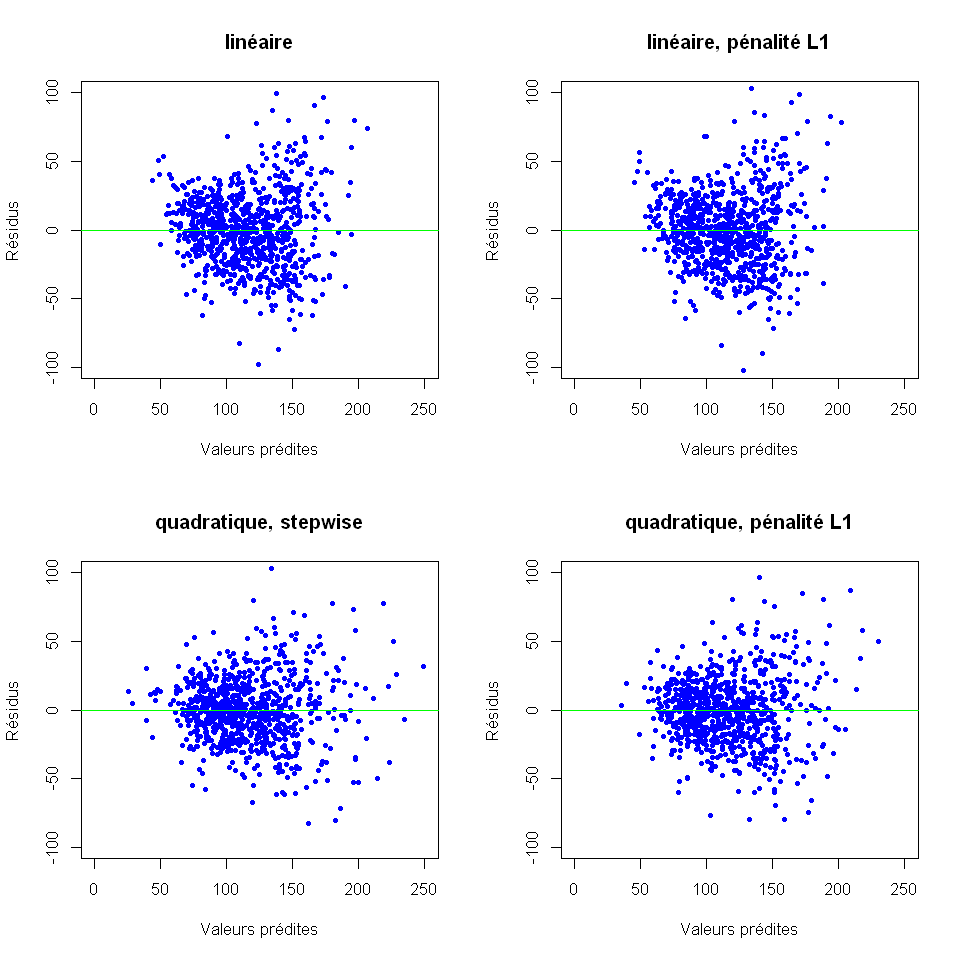

In [69]:
# Extraction des valeurs ajustées et des résidus
fit.glm <- reg.glm.step$fitted.values
res.glm <- reg.glm.step$residuals
fit.lasso2 <- predict(reg.lasso2.cv, s = "lambda.min", newx = x.mat2)
res.lasso2 <- datappr$O3obs - fit.lasso2
# Graphe des résidus
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow = c(2, 2))
plot.res(fit.lm, res.lm, "linéaire")
plot.res(fit.lasso, res.lasso, "linéaire, pénalité L1")
plot.res(fit.glm, res.glm, "quadratique, stepwise")
plot.res(fit.lasso2, res.lasso2, "quadratique, pénalité L1")

On remarque que la présence de certains interactions ou variables sont pertinentes au sens du critère d'Akaïke mais pas significative au sens du test de Fisher. 

Cette présence dans le modèle pourrait être plus finement analysée en considérant une estimation de l'erreur par validation croisée. L'idée serait de retirer une à une les variables ou interactions les moins significatives pour voir comment se comporte la validation croisée. D'autre part, si la procédure pas-à-pas conduit à un modèle différent, l'estimation de l'erreur par validation croisée permet également d'optimiser le choix.

Ces raffinements ne s'avèrent pas efficaces sur ces données. Le modèle obtenu par minimisaiton du critère AIC est conservé.



### Prévision de l'échantillon test


Le modèle "optimal" obtenu par la méthode stepwise est utilisé pour prédire l'échantillon test et estimer ainsi, sans biais, une erreur de prévision. Deux erreurs sont estimées ; la première est celle quadratique pour la régression tandis que la deuxième est issue de la matrice de confusion qui croise les dépassements de seuils prédits avec ceux effectivement observés.

In [71]:
# Calcul des prévisions
pred.glm <- predict(reg.glm.step, newdata = datestr)
# Erreur quadratique moyenne de prévision (MSE)
sum((pred.glm - datestr[, "O3obs"])^2) / nrow(datestr)

[1] 601.5874

In [72]:
# Erreur quadratique par MOCAGE
sum((datestr[,"MOCAGE"] - datestr[,"O3obs"])^2) / nrow(datestr)

[1] 1384.503

In [73]:
# Matrice de confusion pour la prévision du dépassement de seuil
table(pred.glm > 150, datestr[, "O3obs"] > 150)

       
        FALSE TRUE
  FALSE   161   19
  TRUE      5   24

In [74]:
# Matrice de confusion pour la prévision du 
# dépassement de seuil par MOCAGE
table(datestr[, "MOCAGE"] > 150, datestr[, "O3obs"] > 150)

       
        FALSE TRUE
  FALSE   141   19
  TRUE     25   24

Noter ces erreurs pour les comparer avec celles obtenues par les autres méthodes. Noter l'asymétrie des erreurs.

## Prévision par modèle binomial
Plutôt que de prévoir la concentration puis le dépassement, on peut se poser la question de savoir s'il ne serait pas pertinent de prévoir directement la présence ou l'absence d'un dépassement. La variable à modéliser étant binaire, c'est la régression logistique qui va être employée. Comme pour la régression, différentes stratégies de choix de modèle peuvent être utilisées et comparées avant d'estimer l'erreur de prévision sur l'échantillon test.


### Régression logistique sans interaction

In [83]:
# estimation du modèle complet
log.lm <- glm(DepSeuil ~. , data = datappq, family = binomial)
# significativité des paramètres
anova(log.lm, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,831,737.8141,NA
JOUR,1,0.4443555,830,737.3698,5.050277e-01
MOCAGE,1,125.2166123,829,612.1532,4.563158e-29
TEMPE,1,136.8421803,828,475.3110,1.305601e-31
STATION,4,16.9891229,824,458.3219,1.942378e-03
VentMOD,1,11.7860664,823,446.5358,5.967570e-04
VentANG,1,0.8373860,822,445.6984,3.601454e-01
SRMH2O,1,6.4120067,821,439.2864,1.133512e-02
LNO2,1,0.1893011,820,439.0971,6.634989e-01


In [84]:
# Recherche d'un modèle optimal au sens d'Akaïke
log.lm.step <- step(log.lm, direction = "backward")

Start:  AIC=459.72
DepSeuil ~ JOUR + MOCAGE + TEMPE + STATION + VentMOD + VentANG + 
    SRMH2O + LNO2 + LNO

          Df Deviance    AIC
- MOCAGE   1   434.25 458.25
- JOUR     1   434.36 458.36
- VentANG  1   434.60 458.60
<none>         433.72 459.72
- LNO      1   439.10 463.10
- LNO2     1   439.21 463.21
- SRMH2O   1   440.49 464.49
- VentMOD  1   440.90 464.90
- STATION  4   455.47 473.47
- TEMPE    1   550.99 574.99

Step:  AIC=458.25
DepSeuil ~ JOUR + TEMPE + STATION + VentMOD + VentANG + SRMH2O + 
    LNO2 + LNO

          Df Deviance    AIC
- JOUR     1   434.79 456.79
- VentANG  1   435.23 457.23
<none>         434.25 458.25
- SRMH2O   1   441.49 463.49
- VentMOD  1   442.86 464.86
- LNO      1   447.00 469.00
- LNO2     1   451.13 473.13
- STATION  4   471.33 487.33
- TEMPE    1   558.59 580.59

Step:  AIC=456.79
DepSeuil ~ TEMPE + STATION + VentMOD + VentANG + SRMH2O + LNO2 + 
    LNO

          Df Deviance    AIC
- VentANG  1   436.01 456.01
<none>         434.79 456.79

In [85]:
# Modèle obtenu
anova(log.lm.step, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,831,737.8141,NA
TEMPE,1,214.189011,830,523.6251,1.674882e-48
STATION,4,32.315989,826,491.3091,1.648689e-06
VentMOD,1,29.015384,825,462.2937,7.180577e-08
SRMH2O,1,9.116772,824,453.1770,2.532764e-03
LNO2,1,5.017192,823,448.1598,2.509684e-02
LNO,1,12.150777,822,436.0090,4.906743e-04


In [86]:
# matrice de confusion de l'échantillon 
# d'apprentissage et erreur apparente
table(log.lm.step$fitted.values > 0.5, datappq[, "DepSeuil"])

       
        FALSE TRUE
  FALSE   673   70
  TRUE     24   65

## Régression logistique avec interactions

Avec autant de variables et d'interactions donc de paramètres, l'estimation du modèle complet de régression logistique rencontre des soucis et affiche des warnings car certaines probabilité trop bien ajustés (0 ou 1) provoquent des divisions par 0. Ici une procédure forward ou mieux stepwise de sélection des variables et interactions conduit à des résultats raisonnables. Une méthode avec pénalisation L1 peut aussi être utilisée.

In [90]:
# régression avec le modèle minimum
log.qm <- glm(DepSeuil ~ 1, data = datappq,family = binomial)
# algorithme stepwise en précisant le plus grand 
# modèle possible
log.qm.step1 <- step(log.qm, direction = "both",
    scope = list(lower = ~1, upper = ~(JOUR + MOCAGE + TEMPE + 
            STATION + VentMOD + VentANG + LNO2 + LNO + SRMH2O)^2), 
    family=binomial)

Start:  AIC=739.81
DepSeuil ~ 1

          Df Deviance    AIC
+ TEMPE    1   523.63 527.63
+ MOCAGE   1   613.24 617.24
+ SRMH2O   1   683.87 687.87
+ VentANG  1   726.72 730.72
+ STATION  4   721.68 731.68
+ LNO2     1   727.76 731.76
+ VentMOD  1   733.38 737.38
<none>         737.81 739.81
+ LNO      1   736.47 740.47
+ JOUR     1   737.37 741.37

Step:  AIC=527.63
DepSeuil ~ TEMPE

          Df Deviance    AIC
+ MOCAGE   1   476.67 482.67
+ STATION  4   491.31 503.31
+ SRMH2O   1   503.12 509.12
+ VentMOD  1   515.31 521.31
+ VentANG  1   516.54 522.54
<none>         523.63 527.63
+ LNO      1   521.92 527.92
+ JOUR     1   522.78 528.78
+ LNO2     1   523.06 529.06
- TEMPE    1   737.81 739.81

Step:  AIC=482.67
DepSeuil ~ TEMPE + MOCAGE

               Df Deviance    AIC
+ SRMH2O        1   465.50 473.50
+ STATION       4   460.11 474.11
+ LNO           1   470.23 478.23
+ LNO2          1   471.61 479.61
+ VentMOD       1   473.42 481.42
+ VentANG       1   473.55 481.55
<none>  

In [91]:
anova(log.qm.step1, test = "Chisq")

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
,<int>,<dbl>,<int>,<dbl>,<dbl>
NULL,NA,NA,831,737.8141,NA
TEMPE,1,214.189011,830,523.6251,1.674882e-48
MOCAGE,1,46.956415,829,476.6687,7.258302e-12
SRMH2O,1,11.172483,828,465.4962,8.301945e-04
STATION,4,15.922320,824,449.5739,3.125190e-03
VentMOD,1,8.683311,823,440.8906,3.211370e-03
TEMPE:STATION,4,11.682335,819,429.2083,1.987666e-02
MOCAGE:VentMOD,1,5.702069,818,423.5062,1.694493e-02
SRMH2O:STATION,4,15.218744,814,408.2874,4.268380e-03


### Prévision de l'échantillon test

#### Matrice de confusion

In [92]:
# Prévision du modèle quadratique
pred.log <- predict(log.qm.step1, newdata = datestq, type = "response")
# Matrice de confusion pour la prévision du 
# dépassement de seuil
table(pred.log > 0.5, datestq[, "DepSeuil"])

       
        FALSE TRUE
  FALSE   164   20
  TRUE      2   23

Comparer avec l'approche précédente. Mémoriser les résultats obtenus pour comparer avec les autres méthodes.

***
<font color='blue'>
Les modèles ont à peu près les mêmes resultat. Donc le fait de rajouter autant de variable n'est pas utile et risque d'engendrer un problème d'over fitting
</font>

***

## Courbe ROC
Il est également possible de construire une courbe ROC en association de la prévision obtenue à partir d'un modèle gaussien. En effet, la variation du seuil théorique de dépassement (150) va faire varier les proportions respectives des taux de vrais et faux positifs. Cela revient encore à faire varier le seuil d'une "proba" pour les valeurs de prévisions divisées par 300.

In [ ]:
install.packages("ROCR")

In [94]:
library(ROCR)

Warning message:
"le package 'ROCR' a été compilé avec la version R 4.1.3"


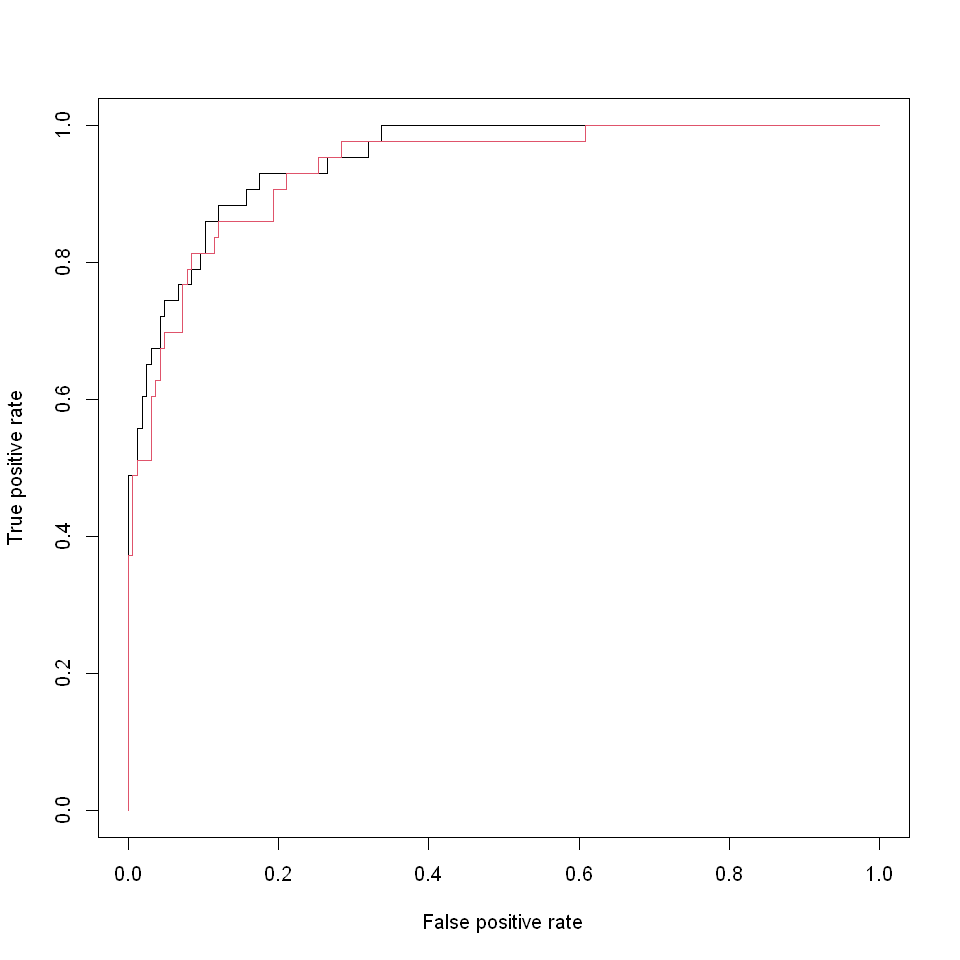

In [95]:
roclogit <- predict(log.qm.step1, newdata = datestq, type="response")
predlogit <- prediction(roclogit, datestq[, "DepSeuil"])
perflogit <- performance(predlogit, "tpr", "fpr")
# Tracé de la courbe
plot(perflogit, col = 1)
# Calculs pour la régression
rocglm <- pred.glm / 300
predglm <- prediction(rocglm, datestq[, "DepSeuil"])
perfglm <- performance(predglm, "tpr", "fpr")
# tracé de la courbe et ajout au graphe précédent.
plot(perfglm, col = 2, add = TRUE)

***
**Q** Que sont sensibilité et spécificité d'une courbe ROC?

<font color='blue'>
La courbe ROC est une mesure de la performance d'un classificateur binaire, c'est-à-dire d'un système qui a pour objectif de catégoriser des éléments en deux groupes distincts sur la base d'une ou plusieurs des caractéristiques de chacun de ces éléments. Graphiquement, on représente souvent la mesure ROC sous la forme d'une courbe qui donne le taux de vrais positifs (fraction des positifs qui sont effectivement détectés) en fonction du taux de faux positifs (fraction des négatifs qui sont incorrectement détectés).
    
   - La sensibilité est la proportion de vrais positifs 
   - La spécificité est la proportion de vrais négatifs
</font>

Les résultats obtenus dépendent évidemment en plus de l'échantillonnage initial entre apprentissage et test. Dans le cas où les courbes se croisent, cela signifie qu'il n'y a pas de prévision uniformément meilleure de l'occurrence de dépassement. Cela dépend de la sensibilité ou de la spécificité retenue pour le modèle. Ceci souligne l'importance de la bonne définition du critère à utiliser pour le choix d'une "meilleure" méthode. Ce choix dépend directement de celui , "politique" ou "économique" de sensibilité et / ou spécificité du modèle retenu. En d'autres termes, quel taux de fausse alerte, avec des imputations économiques évidentes, est supportable au regard des dépassements non détectés et donc de la dégradation sanitaire de la population à risque ?



C'est une fois ce choix arrêté que le statisticien peut opérer une comparaison des méthodes en présence.

**Q** Les performances des deux approches gaussiennes et binomiales sont-elles très différentes?

<font color="blue">Les courbes se croisent sur de grandes intervalles, ce qui signifie que les deux approches ne sont pas très différentes.</font>


***

## Arbre de décision binaire

La librairie  `rpart` est celle la plus couramment utilisée pour la construction d'arbres de décision. Deux types d'arbre peuvent être estimer selon que la variable à modéliser est la concentration d'ozone (arbre de régression) ou directement le dépassement du seuil (arbre de discrimination ou de décision). Différents paramètres  contrôlent l'exécution de l'algorithme: la pénalisation  minimale (`cp`) pour la construction de l'arbre maximal, le nombre minimal d'observation par noeud, le nombre de validations croisées (par défaut 10)... cf. l'aide en ligne (?rpart.control) pour plus de détails mais celle-ci n'est pas très explicite sur certains paramètres, c'est le travers des logiciels "libres".

**NB.** Une séquence de valeurs de la pénalisation `cp` est associée à une séquence d'arbres emboîtés.

***
### Estimation et élagage de l'arbre de régression
**Q** Quel critère est optimisé lors de la création d'un noeud? de l'arbre?

<FONT COLOR="Blue">
Le critère optimisé est la homogénéité des descendants par rapport à la variable cible, la variable qui est testée dans un nœud sera celle qui maximise cette homogénéité (entropie, concentration de Ginie..).
</FONT>

***

In [140]:
library(rpart) # chargement de la librairie
tree.reg=rpart(O3obs~.,data=datappr,control=rpart.control(cp=0.001))
# La commande ci-dessous fournit un descriptif de l'arbre obtenu
summary(tree.reg)  
# mais un graphe est  préférable

Call:
rpart(formula = O3obs ~ ., data = datappr, control = rpart.control(cp = 0.001))
  n= 832 

            CP nsplit rel error    xerror       xstd
1  0.300779873      0 1.0000000 1.0031262 0.06844502
2  0.120979682      1 0.6992201 0.7071789 0.05124343
3  0.061988815      2 0.5782404 0.6482374 0.04013483
4  0.031806100      3 0.5162516 0.5869364 0.03630480
5  0.022307456      4 0.4844455 0.5639235 0.03509489
6  0.014827909      5 0.4621381 0.5453343 0.03450642
7  0.012718031      6 0.4473102 0.5576402 0.03549763
8  0.009660996      7 0.4345921 0.5538592 0.03541863
9  0.007238599      8 0.4249311 0.5402019 0.03383767
10 0.007204683      9 0.4176925 0.5354287 0.03265721
11 0.006717601     11 0.4032832 0.5333492 0.03261178
12 0.006590831     12 0.3965656 0.5369934 0.03327303
13 0.006384876     13 0.3899747 0.5394562 0.03325858
14 0.006158566     14 0.3835899 0.5439941 0.03339823
15 0.005791214     15 0.3774313 0.5355169 0.03259297
16 0.004885358     17 0.3658489 0.5316466 0.03216253
17

In [141]:
library(rpart)
help(rpart)


In [142]:
help(rpart.control)

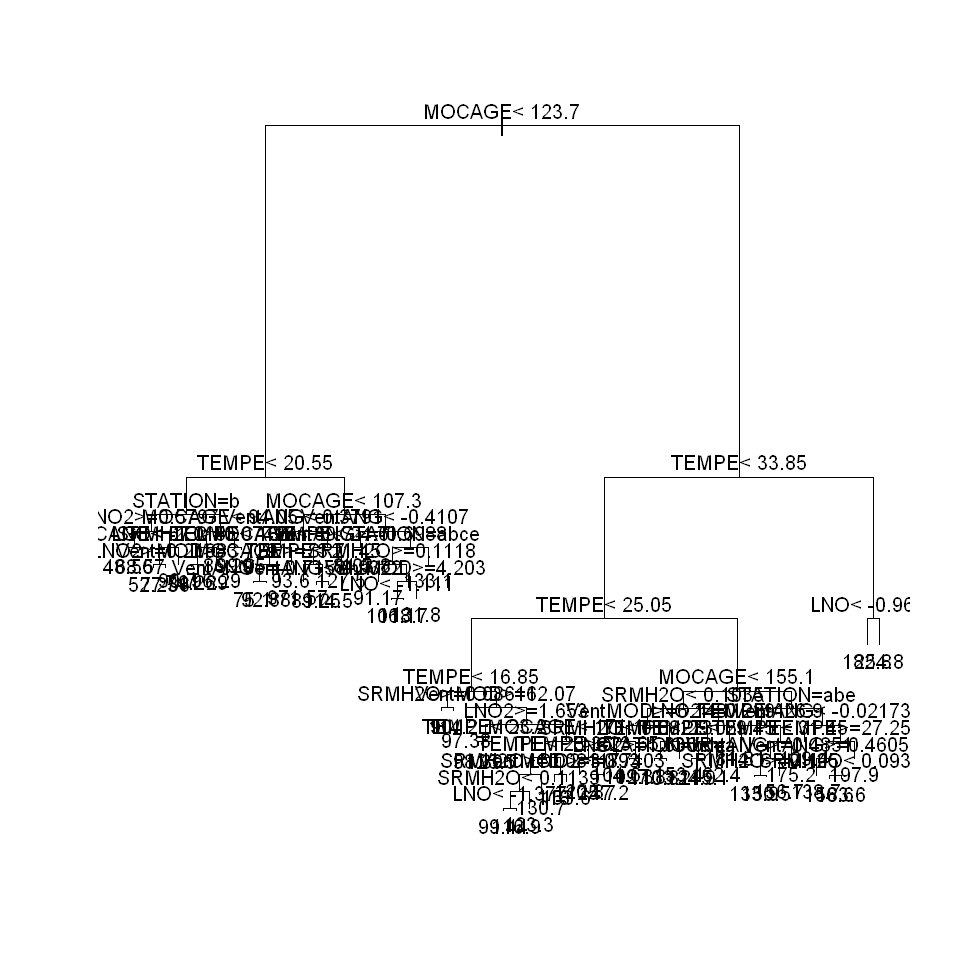

In [143]:
plot(tree.reg)
text(tree.reg)

L'arbre est illisible et présente trop de feuilles pour une bonne prévision (sur-apprentissage), il est nécessaire d'en réduire le nombre par élagage. Les commandes suivantes calculent les prévisions obtenues par  validation croisée *10-fold* pour chaque arbre élagué suivant les valeurs successives du coefficient de complexité. La séquence de ces valeurs est implicitement celle fournit par `rpart`. 

In [144]:
xmat=xpred.rpart(tree.reg)
xerr=(xmat-datappr[,"O3obs"])^2
CVerr=apply(xerr,2,sum)
CVerr  #    CP           erreur

0.650389937 0.190757054 0.086599002 0.044402955 0.026636689 0.018187164 
  1397743.1    990283.4    896783.8    821829.4    770800.7    746140.8 
0.013732509 0.011084622 0.008362540 0.007221621 0.006956881 0.006653914 
   744324.9    749104.5    760141.7    755098.5    747729.6    753730.0 
0.006487036 0.006270700 0.005972066 0.005319037 0.004732087 0.004557061 
   756256.8    759090.6    766174.5    763637.0    766477.6    772121.0 
0.004513292 0.004302262 0.004031475 0.003886693 0.003757776 0.003456486 
   774939.0    767383.5    759209.0    748664.8    752249.6    758952.8 
0.002930327 0.002647561 0.002567387 0.002437882 0.002374911 0.002342909 
   756410.9    759248.9    759076.3    760974.8    760084.3    759837.6 
0.002280352 0.002186360 0.002005132 0.001884622 0.001785959 0.001682822 
   759162.8    759128.4    755592.3    757236.3    756915.6    762822.5 
0.001630264 0.001587103 0.001579396 0.001451242 0.001333661 0.001326259 
   763209.7    761797.4    761557.6    760263.4    763874.3    763874.3 
0.001314821 0.001281492 0.001246655 0.001224731 0.001193056 0.001087566 
   764798.8    765929.9    766819.2    766936.5    766977.3    767498.5 
0.001004035 
   766891.4

In [145]:
as.numeric(attributes(which.min(CVerr))$names)

[1] 0.01373251

In [146]:
tree.reg=rpart(O3obs~.,data=datappr,control=rpart.control(cp=as.numeric(attributes(which.min(CVerr))$names)))

La librairie partykit propose une construction graphique de l'arbre:

In [147]:
install.packages("partykit")

Warning message:
"le package 'partykit' est en cours d'utilisation et ne sera pas installé"


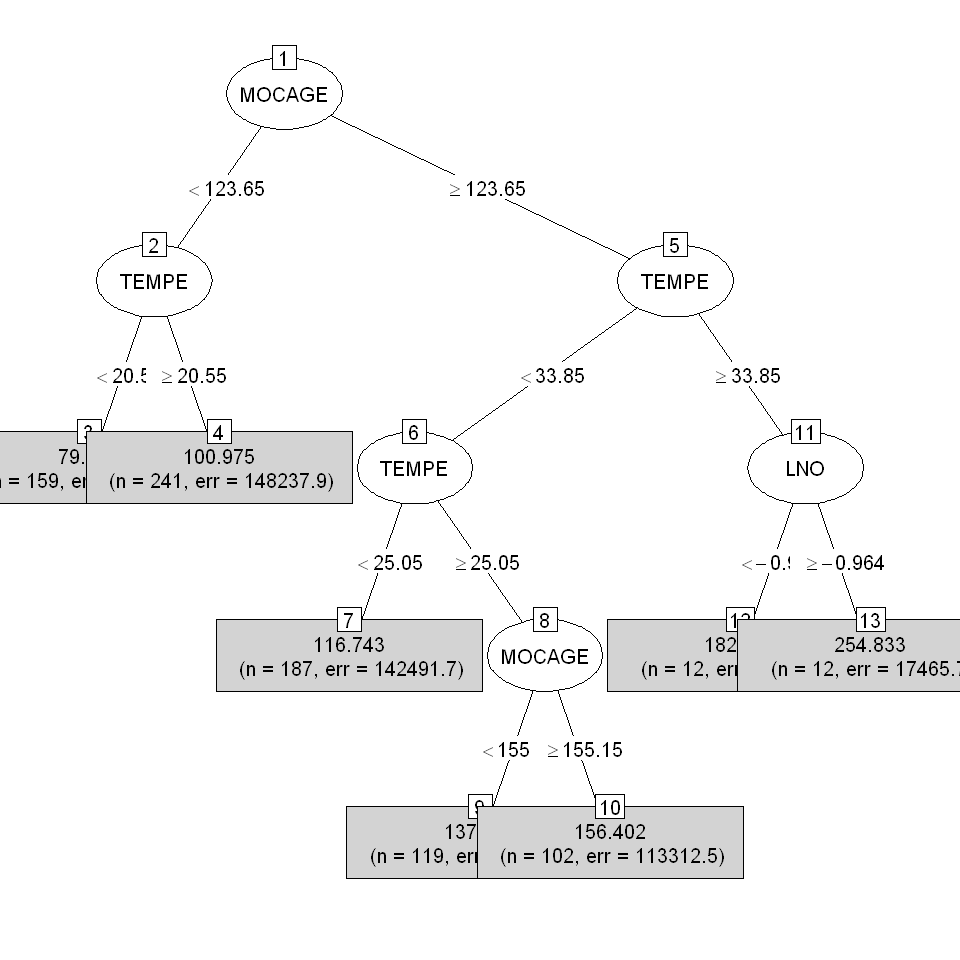

In [148]:
library(partykit)
plot(as.party(tree.reg), type="simple")

La fenêtre est trop petite pour représenter les distributions (histogramme) de la variable cible (concentration en ozone) dans chaque feuille.

***

**Q** Quelle est la variable qui contribue le plus à l'interprétation?

<FONT COLOR="Blue">
    
La variable qui contribue le plus à l'interprétation est la variable MOCAGE, car c'est la variable qui a l'entropie la plus importante et donc mise à la racine de l'arbre.
</FONT>
*** 

Graphe des résidus

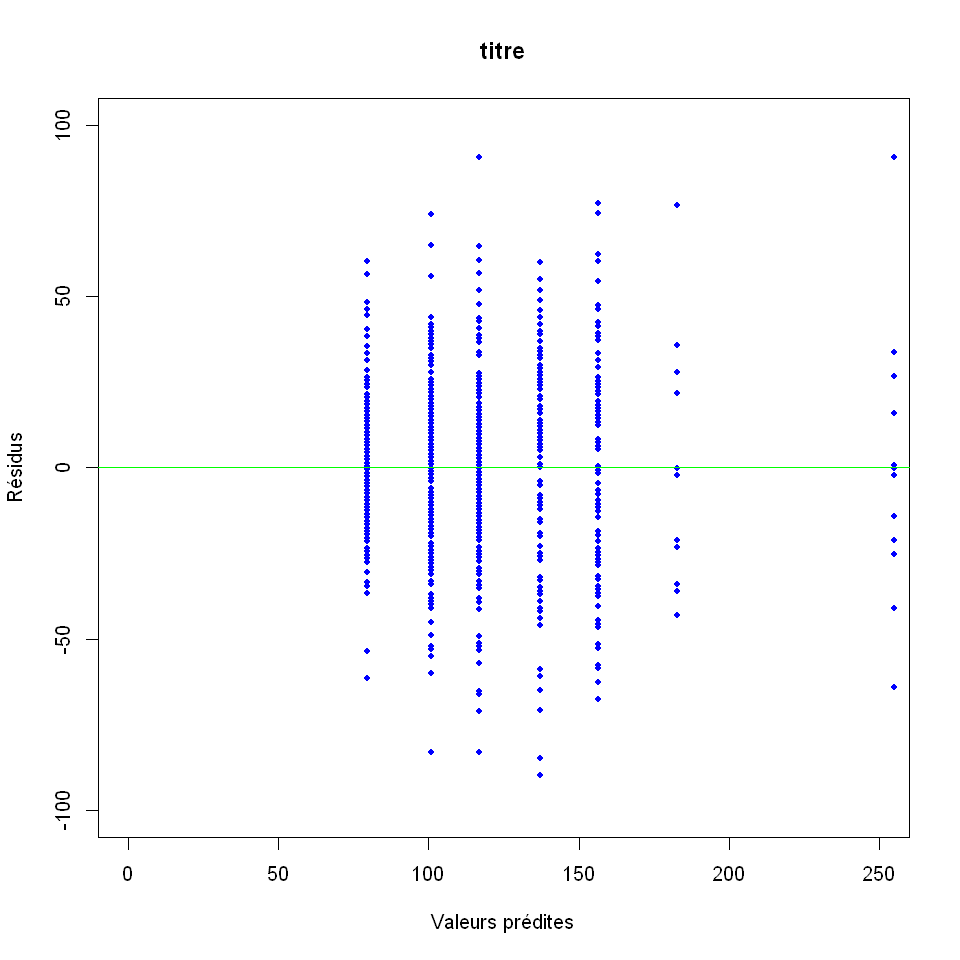

In [149]:
fit.tree=predict(tree.reg)
res.tree=fit.tree-datappr[,"O3obs"]
plot.res(fit.tree,res.tree)

***
**Q** A quoi est due la structure particulière de ce graphe?

<FONT COLOR="Blue">
Le graphique ci-dessus présente les résidus de l’échantillon test du modèle d’arbre de régression qui prennent une structure particulière car les observations (données test) communes à une feuille terminale ont la même valeur, il y a donc une colonne par feuille.
    </font>

***

## Estimation et élagage d'un arbre de discrimination

Dans le cas d'une discrimination, le critère par défaut est l'indice de concentration de Gini ; il est possible de préciser un autre critère (split="information") ainsi que des poids sur les observations, une matrice de coûts de mauvais classement ainsi que des probabilités a priori (?rpart pour plus de détails).

***
**Q** Quel autre critère d'hétérogénéité est utilisé?

<FONT COLOR="Blue">
- L'entropie (Y qualitative) et la variance (si Y quantitative)
</FONT>

***

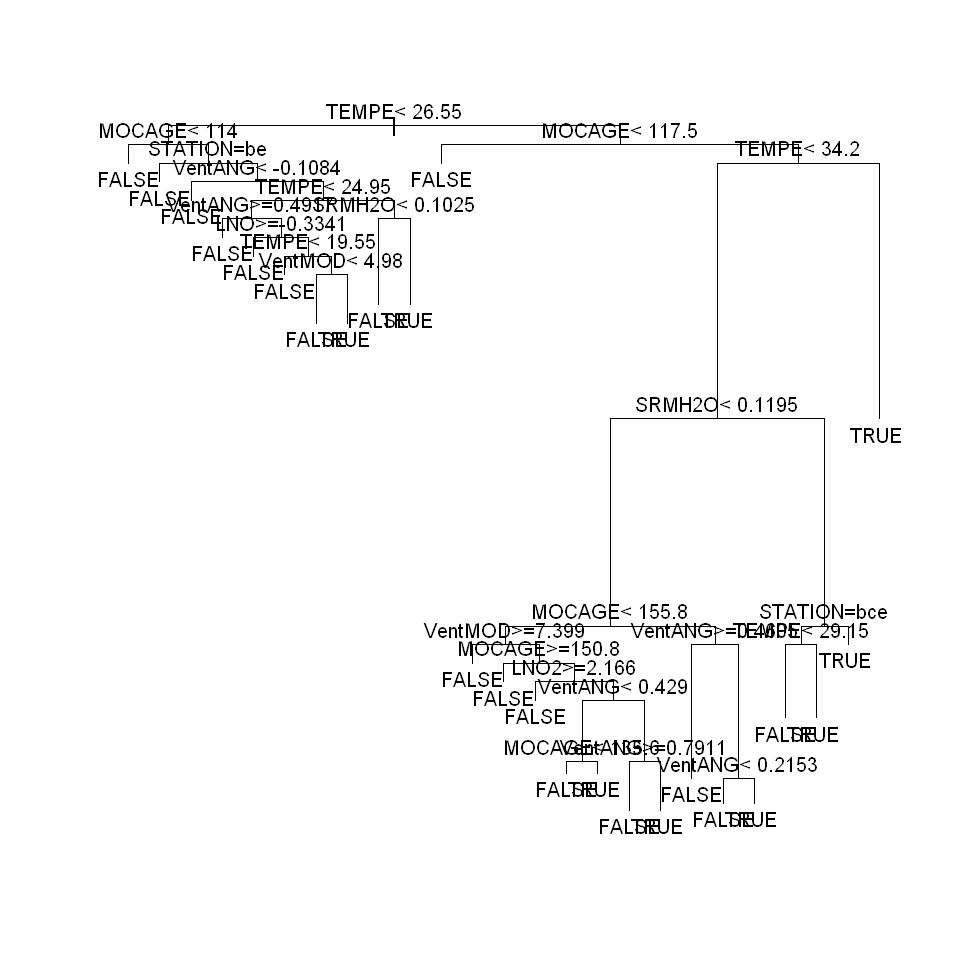

In [150]:
tree.dis=rpart(DepSeuil~.,data=datappq,parms=list(split="information"),cp=0.001)
plot(tree.dis) 
text(tree.dis)

La même procédure d'élagage par validation croisée est mise en place mais avec un expression différente de l'erreur de prévision: taux de mal classés plutôt qu'erreur quadratique.

In [151]:
xmat = xpred.rpart(tree.dis)
# Comparaison des valeurs prédite et observée
xerr=datappq$DepSeuil!= (xmat>1.5) 
# Calcul  des estimations des taux d'erreur
CVerr=apply(xerr, 2, sum)/nrow(xerr)
CVerr

0.525925926 0.045961754 0.030089031 0.018144368 0.012394963 0.009799079 
  0.1622596   0.1370192   0.1370192   0.1442308   0.1478365   0.1550481 
0.008281733 0.002721655 
  0.1550481   0.1634615

In [152]:
as.numeric(attributes(which.min(CVerr))$names)

[1] 0.04596175

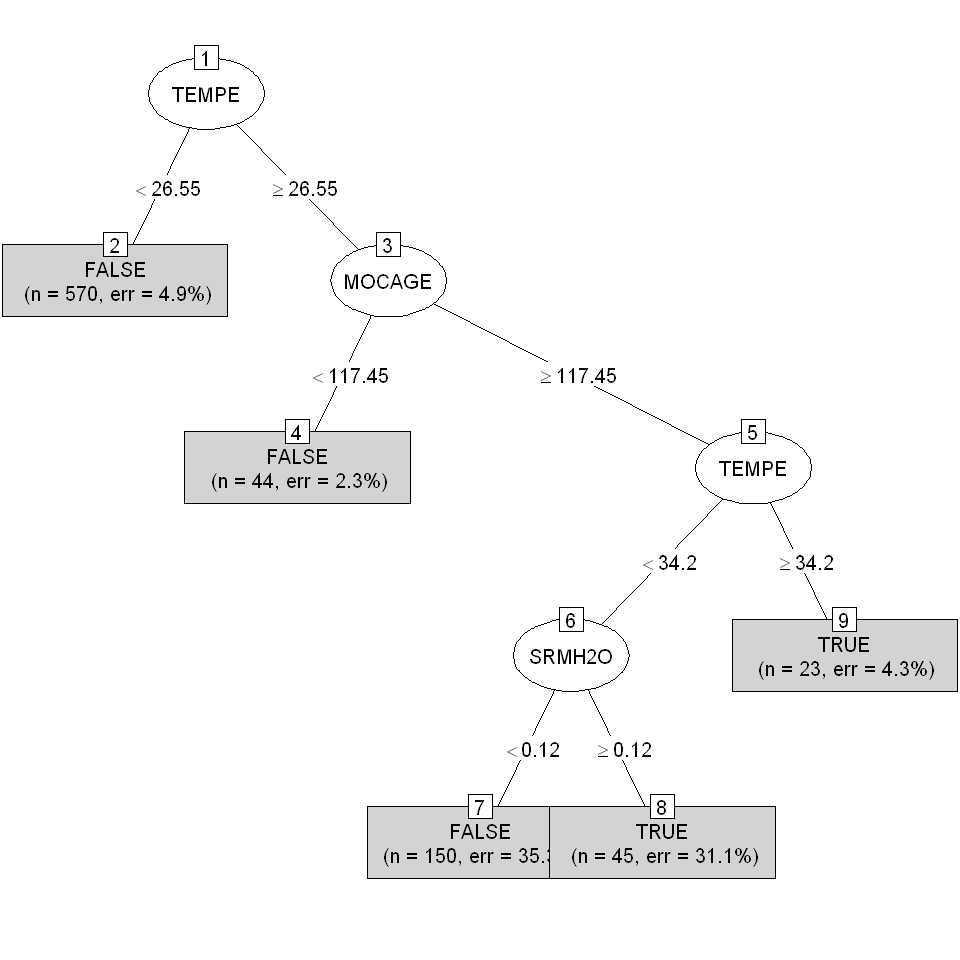

In [153]:
tree.dis=rpart(DepSeuil~.,data=datappq,parms=list(split="information"),
               cp=as.numeric(attributes(which.min(CVerr))$names))
plot(as.party(tree.dis), type="simple")

## Prévision de l'échantillon test

Différentes prévisions sont considérées assorties des erreurs estimées sur l'échantillon test. Prévision quantitative de la concentration, prévision de dépassement à partir de la prévision quantitative et directement la prévision de dépassement à partir de l'arbre de décision.

In [154]:
# Calcul des prévisions
pred.treer=predict(tree.reg,newdata=datestr)
pred.treeq=predict(tree.dis,newdata=datestq,type="class") 
# Erreur quadratique moyenne de prévision en régression
sum((pred.treer-datestr[,"O3obs"])^2)/nrow(datestr)

[1] 848.1622

In [155]:
# Matrice de confusion pour la prévision du 
# dépassement de seuil (régression)
table(pred.treer>150,datestr[,"O3obs"]>150)

       
        FALSE TRUE
  FALSE   157   24
  TRUE      9   19

In [156]:
# Même chose pour l'arbre de discrimination
table(pred.treeq,datestq[,"DepSeuil"])

          
pred.treeq FALSE TRUE
     FALSE   165   28
     TRUE      1   15

***
**Q** Quelle stratégie semble meilleure à ce niveau?

<FONT COLOR="Blue">
La matrice de confusion pour la prévision du dépassement de seuil montre 33 mal classés comparé à 29 pour l'abre de discrimination. On peut donc penser que l'arbre de discrimination est la meilleure stratégie. Cependant, cela peut changer.</font>

***

## Courbes ROC

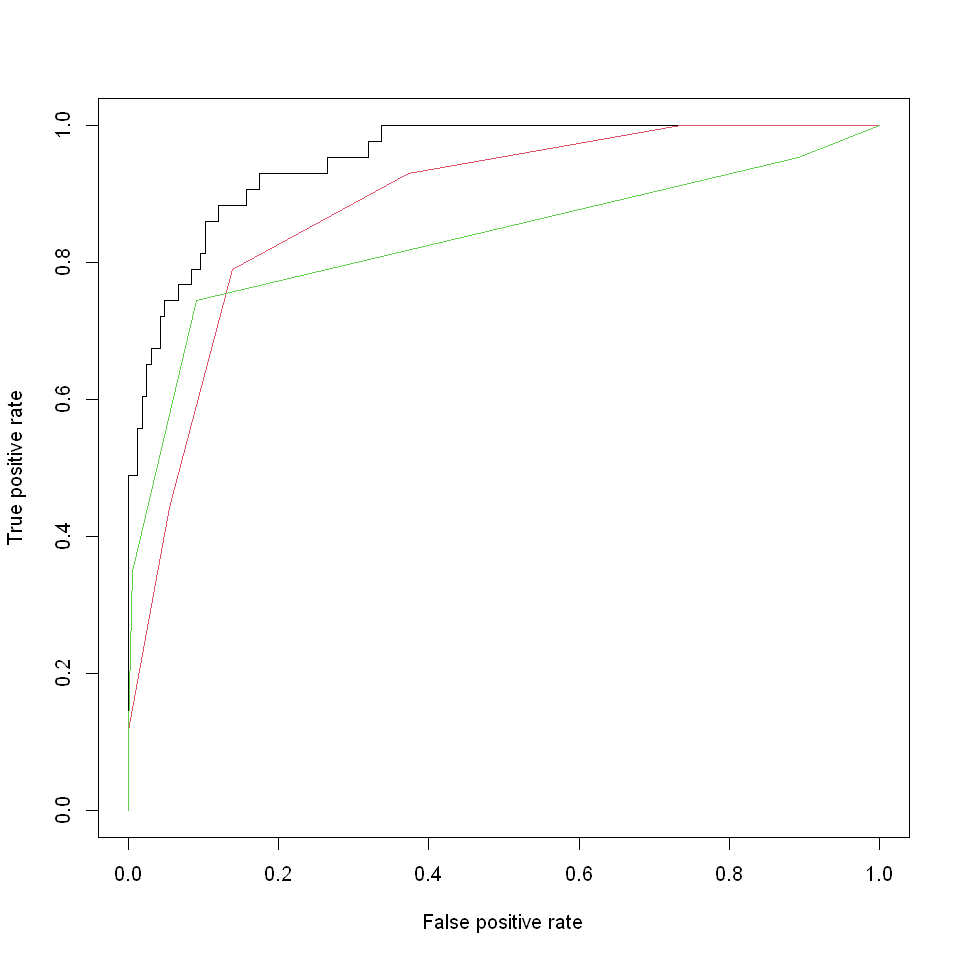

In [157]:
ROCregtree=pred.treer/300
predregtree=prediction(ROCregtree,datestq$DepSeuil)
perfregtree=performance(predregtree,"tpr","fpr")
ROCdistree=predict(tree.dis,newdata=datestq,type="prob")[,2]
preddistree=prediction(ROCdistree,datestq$DepSeuil)
perfdistree=performance(preddistree,"tpr","fpr")
# tracer les courbes ROC en les superposant 
# pour mieux comparer
plot(perflogit,col=1)
plot(perfregtree,col=2,add=TRUE) 
plot(perfdistree,col=3,add=TRUE)

***
Comparer les qualités  de prévision.

**Q** Une meilleure méthode se dégage-t-elle?

<font color="blue">
On observe que l'arbre de discrimination est le moins performant. logit est meilleure que L'arbre de régression (regtree) et l'arbre de discrimination (distree). On peut donc conclure que la méthode logit est la meilleur. Mais cela peut changer.</font>

***

## Réseau de neurones

### Introduction

Il s'agit d'estimer un modèle de type *perceptron* avec en entrée les variables qualitatives ou quantitatives et en sortie la variable à prévoir. Des fonctions R pour l'apprentissage d'un perceptron élémentaire ont été réalisées par différents auteurs et sont accessibles sur le réseau. La librairie `nnet` de (Ripley, 1999), est limitée au perceptron à une couche. Ce n'est pas de l'*apprentissage profond* ! mais suffisant dans bien des cas. Une librairie R associée au logiciel éponyme H2O propose des réseaux à plusieurs couches et "convolutionnels".

Comme pour les arbres, la variable à expliquer est soit quantitative soit qualitative ; la fonction de transfert du neurone de sortie d'un réseau doit être adaptée en conséquence.

*** 
**Q** Quelle fonction de transfert pour le dernier neurone en régression ?

<font color="blue">
- La fonction linéaire identité
</font>


**Q** Quelle fonction de transfert pour le dernier neuronne en discrimination binaire?

<font color="blue"> 
En discrimination (classification en anglais) binaire, la fonction de transfert pour le neurone de sortie est la fonction $sigmoïde$.
    
</font>


**Q** Quid de la discrimination avec plusieurs classes?

<font color="blue">
Dans le cas d'une discrimination à plusieurs classes, le neurone de sortie intègre une focntion d'activation $softmax$ à valeurs dans $R^n$ et de somme unit. Ces $n$ valeurs sont assimilables à des probabilités d'appartenance à une classe.
</font>


**Q** Quel est le choix par défaut pour les neurones de la couche cachée?

<font color="blue"> 
- La fonction sigmoide</font>



Différentes stratégies sont proposées pour éviter le sur-apprentissage. La première conciste à optimiser le nombre de neurones sur la couche cachée. Très approximativement il est d'usage de considérer, qu'en moyenne, il faut une taille d'échantillon d'apprentissage 10 fois supérieure au nombre de poids c'est-à-dire au nombre de paramètres à estimer. On remarque qu'ici la taille de l'échantillon d'apprentissage (832) est modeste pour une application raisonnable du perceptron. Seuls des nombres restreints de neurones peuvent être considérés et sur une seule couche cachée. 

**Q** Quel est le paramètre `decay` de la fonction `nnet`?

<font color="blue">
Le paramètre `decay` de la fonction `nnet` permet la régularisation. Par défaut il est à 0 ce qui signifie qu'il n'y a pas de régularisation. Plus la valeur du paramètre `decay` est importante, moins les poids des entrées des neurones peuvent prendre des valeurs chaotiques contribuant ainsi à limiter les risques de sur-apprentissage. Cette méthode de régularisation consiste à ajouter une pénalité à la fonction d'erreur qui dépend de la magnitude des poids qui relient les neurones entre eux. </font>

**Q** Indiquer une autre façon déviter le sur-apprentissage.

<font color="blue">Afin d'éviter le sur-apprentissage, en plus du paramètre `decay`, il est possible de limiter le nombre de neurones ou la durée d'apprentissage. </font>

***

### Cas de la régression

In [158]:
library(MASS)
library(nnet)
# apprentissage
# attention au paramètre linout dans le cas de la régression
nnet.reg=nnet(O3obs~.,data=datappr,size=5,decay=1,linout=TRUE,maxit=500) 
summary(nnet.reg)

# weights:  71
initial  value 12615089.484843 
iter  10 value 1513609.869575
iter  20 value 1407628.762917
iter  30 value 1220996.415052
iter  40 value 1021621.632562
iter  50 value 847420.764001
iter  60 value 802847.197496
iter  70 value 770717.685923
iter  80 value 735050.934577
iter  90 value 723590.814407
iter 100 value 677651.716563
iter 110 value 657138.980591
iter 120 value 614778.021204
iter 130 value 599436.435916
iter 140 value 593801.890030
iter 150 value 564733.042995
iter 160 value 554200.005631
iter 170 value 539753.758609
iter 180 value 528289.254416
iter 190 value 524238.500099
iter 200 value 523358.163460
iter 210 value 522798.993881
iter 220 value 522547.698223
iter 230 value 522378.788943
iter 240 value 522316.695585
final  value 522312.514581 
converged


a 12-5-1 network with 71 weights
options were - linear output units  decay=1
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
   0.59    0.45    0.02    0.17   -1.84   -0.23    0.25   -0.37   -0.08    0.35 
i10->h1 i11->h1 i12->h1 
 -29.66   -1.19    0.59 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
 -11.04    0.14    0.01    0.33    0.77    0.38    1.68    0.35   -0.08    0.08 
i10->h2 i11->h2 i12->h2 
  20.66   -1.51    1.72 
  b->h3  i1->h3  i2->h3  i3->h3  i4->h3  i5->h3  i6->h3  i7->h3  i8->h3  i9->h3 
   2.32   38.45   -0.38    1.77    3.59   -7.65   23.24   -8.48   -1.97    0.87 
i10->h3 i11->h3 i12->h3 
  -0.51   10.30   -6.93 
  b->h4  i1->h4  i2->h4  i3->h4  i4->h4  i5->h4  i6->h4  i7->h4  i8->h4  i9->h4 
  16.24    0.65   -0.01   -0.58   17.93    4.64   14.95   -7.61   -1.42   -0.38 
i10->h4 i11->h4 i12->h4 
  -4.83   12.81   -2.22 
  b->h5  i1->h5  i2->h5  i3->h5  i4->h5  i5->h5  i6->h5  i7->h5  i8->h5  i9

La commande donne la "trace" de l'exécution avec le comportement de la convergence mais le détail des poids de chaque entrée de chaque neurone ne constituent pas des résultats très explicites ! Contrôler le nombre de poids estimés.

L'optimisation des paramètres nécessite encore le passage par la validation croisée. Il n'y a pas de fonction dans la librairie `nnet` permettant de le faire mais la fonction ` tune.nnet` de la librairie `e1071` est adaptée à cette démarche.

In [162]:
install.packages("e1071")

Warning message:
"le package 'e1071' est en cours d'utilisation et ne sera pas installé"


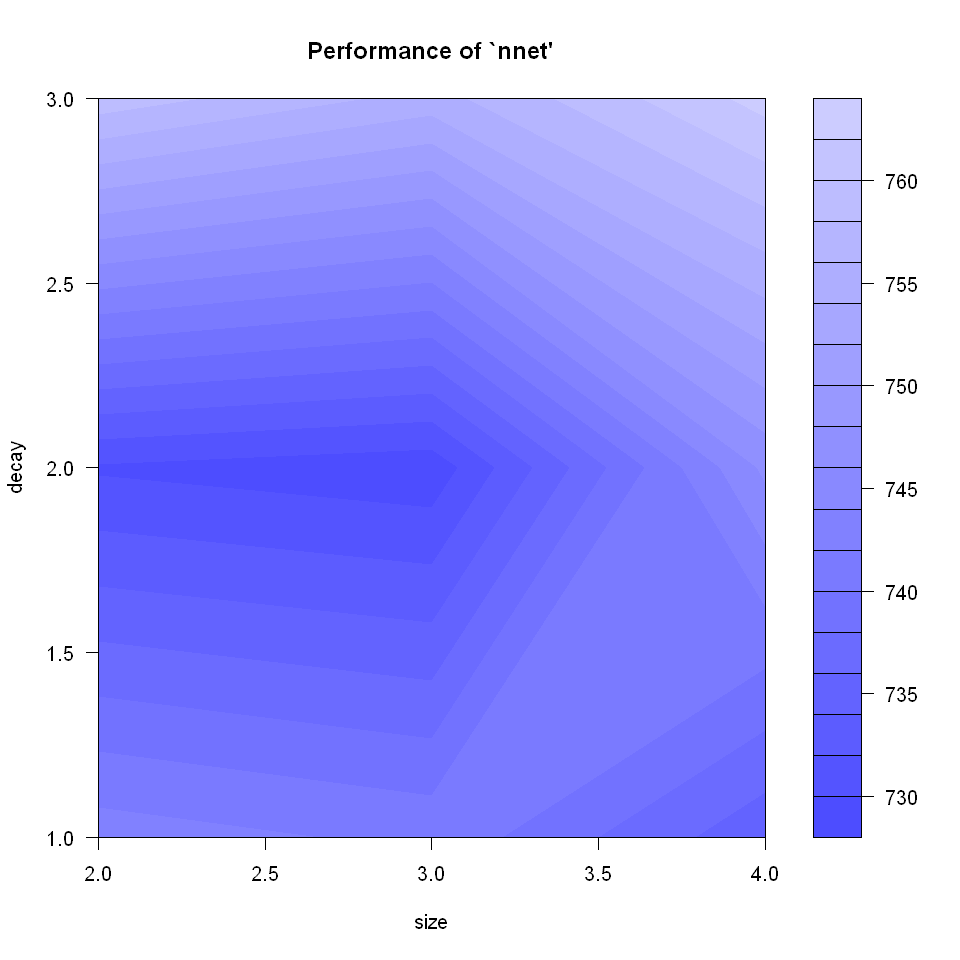

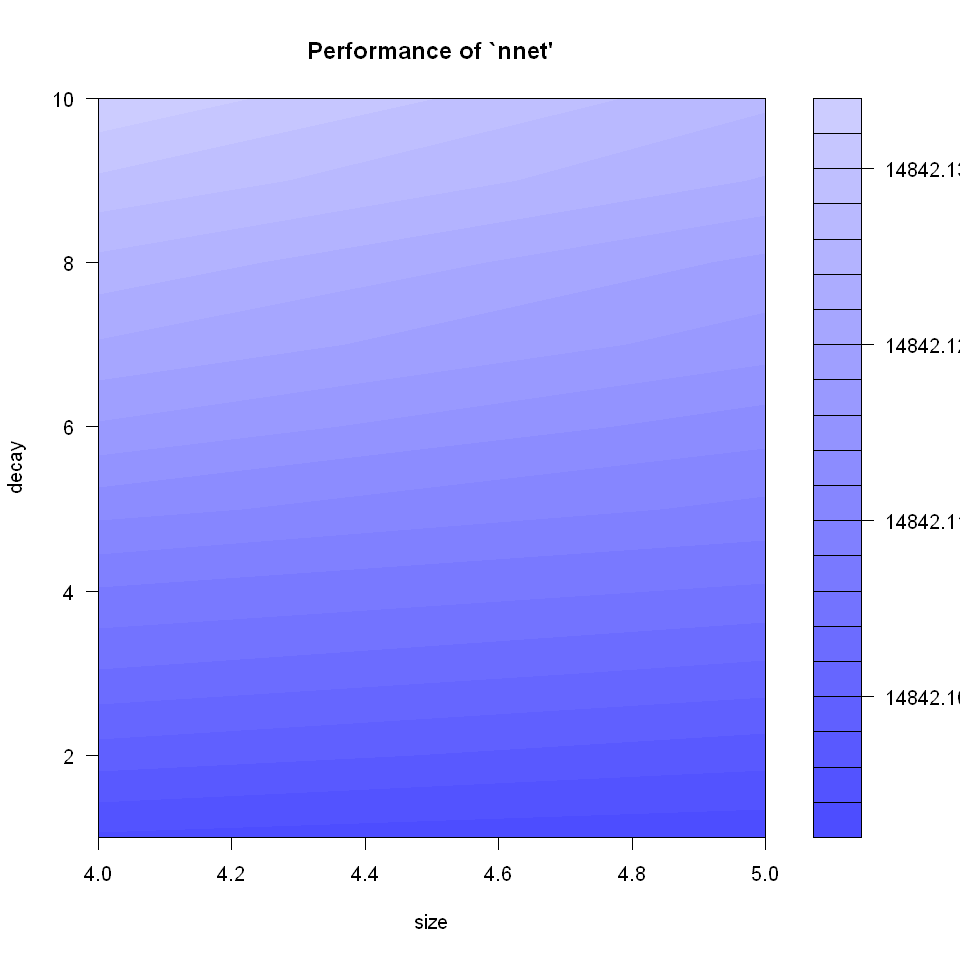

In [165]:
library(e1071)
plot(tune.nnet(O3obs~.,data=datappr,size=c(2,3,4),decay=c(1,2,3),maxit=200,linout=TRUE))
plot(tune.nnet(O3obs~.,data=datappr,size=4:5,decay=1:10))

Faire éventuellement varier la grille des paramètres (zoom), noter la taille et le `decay` optimaux. Il faudrait aussi  faire varier le nombre total d'itérations. Cela risque de prendre un peu de temps ! Noter également que chaque exécution donne des résultats différents... il n'est donc pas très utile d'y passer beaucoup de temps !

Ré-estimer le modèle supposé optimal avant de tracer le graphe des résidus. 

# weights:  43
initial  value 12568046.355266 
iter  10 value 1418476.304905
iter  20 value 1374539.065409
iter  30 value 1315267.827089
iter  40 value 1199787.400219
iter  50 value 920357.243480
iter  60 value 835549.195820
iter  70 value 778007.381578
iter  80 value 754772.043454
iter  90 value 684787.674029
iter 100 value 650427.728885
iter 110 value 644553.096912
iter 120 value 635729.075569
iter 130 value 628208.528541
iter 140 value 622134.042615
iter 150 value 612267.022383
iter 160 value 606073.405222
iter 170 value 593305.273559
iter 180 value 580388.568195
iter 190 value 572942.811838
iter 200 value 562545.701378
final  value 562545.701378 
stopped after 200 iterations


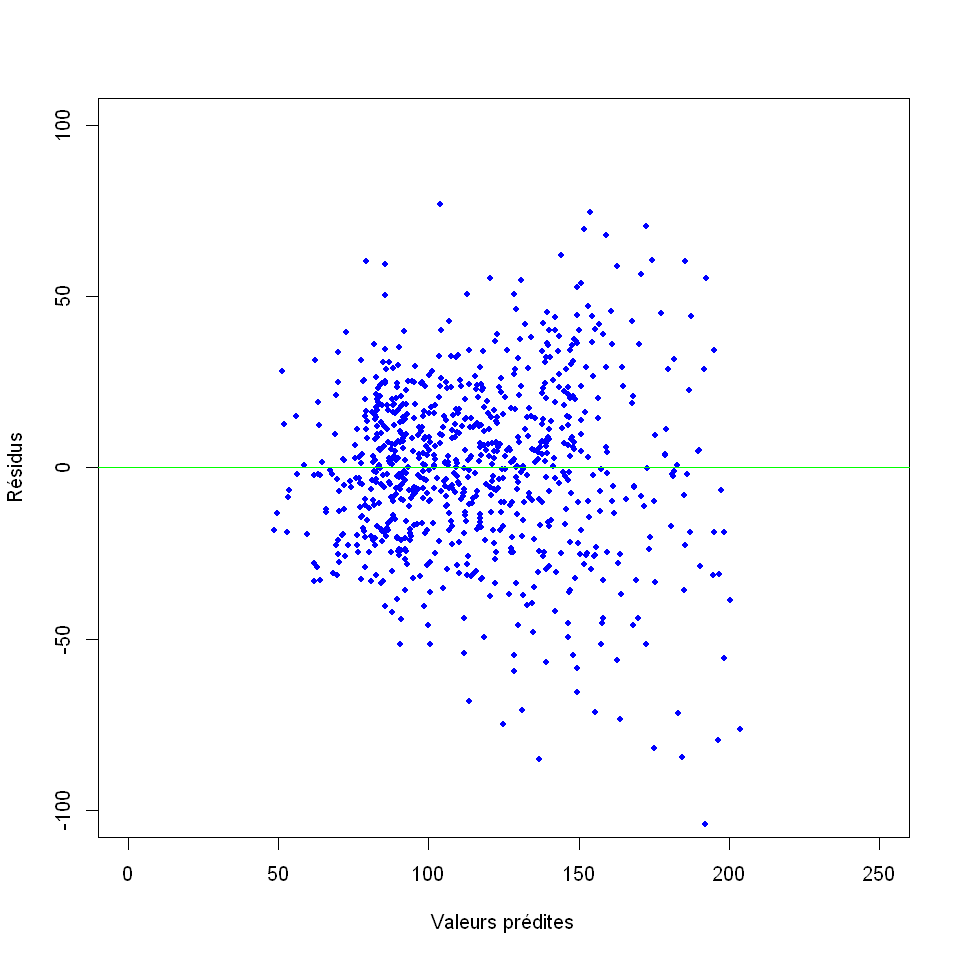

In [164]:
nnet.reg=nnet(O3obs~.,data=datappr,size=3,decay=2,linout=TRUE,maxit=200)
# calcul et graphe des résidus
fit.nnetr=predict(nnet.reg,data=datappr)
res.nnetr=fit.nnetr-datappr[,"O3obs"]
plot.res(fit.nnetr,res.nnetr,titre="")

<font color="blue"> La visualisation des résidus montre que le problème de non-linéarité sur les modèles MOCAGE et regression linéaire est bien résolu et que les résidus sont moins étendus. Cependant, le phénomène d'hétéroscédasticité est toujours présent.</font>

### Cas de la discrimination

In [166]:
# apprentissage
nnet.dis=nnet(DepSeuil~.,data=datappq,size=5,decay=0) 
summary(nnet.reg)

# weights:  71
initial  value 712.060467 
iter  10 value 330.733197
iter  20 value 305.436190
iter  30 value 279.728873
iter  40 value 268.015598
iter  50 value 266.314987
iter  60 value 250.789955
iter  70 value 234.224823
iter  80 value 230.337755
iter  90 value 219.174377
iter 100 value 217.901234
final  value 217.901234 
stopped after 100 iterations


a 12-3-1 network with 43 weights
options were - linear output units  decay=2
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
  -4.95   -0.17    0.13   -0.19    1.00   -1.85   -0.35   -3.17    0.06    3.18 
i10->h1 i11->h1 i12->h1 
 -23.36   -2.20    1.39 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
   3.67   -1.66   -0.13    0.76  -12.54    3.30   -3.69   -1.79   -0.58    0.07 
i10->h2 i11->h2 i12->h2 
 -29.79    3.84   -3.48 
  b->h3  i1->h3  i2->h3  i3->h3  i4->h3  i5->h3  i6->h3  i7->h3  i8->h3  i9->h3 
  -8.27    0.24    0.04    0.27    2.59    0.65    2.55    0.63   -0.05   -0.24 
i10->h3 i11->h3 i12->h3 
  12.44   -3.95    3.99 
  b->o  h1->o  h2->o  h3->o 
 40.48  33.70  41.46  92.30 

La validation croisée est toujours nécessaire afin de tenter d'optimiser les choix en présence : nombre de neurones, `decay` et éventuellement le nombre max d'itérations. 

L'initialisation de l'apprentissage d'un réseau de neurone comme celle de l'estimation de l'erreur par validation croisée sont aléatoires. Chaque exécution donne donc des résultats différents. À ce niveau, il serait intéressant de construire un plan d'expérience à deux facteurs (ici, les paramètres de taille et `decay`) de chacun trois niveaux. Plusieurs réalisations pour chaque combinaison des niveaux suivies d'un test classique d'anova permettraient de se faire une idée plus juste de l'influence de ces facteurs sur l'erreur. 

Noter la taille et le `decay` optimaux et ré-estimer le modèle pour ces valeurs.

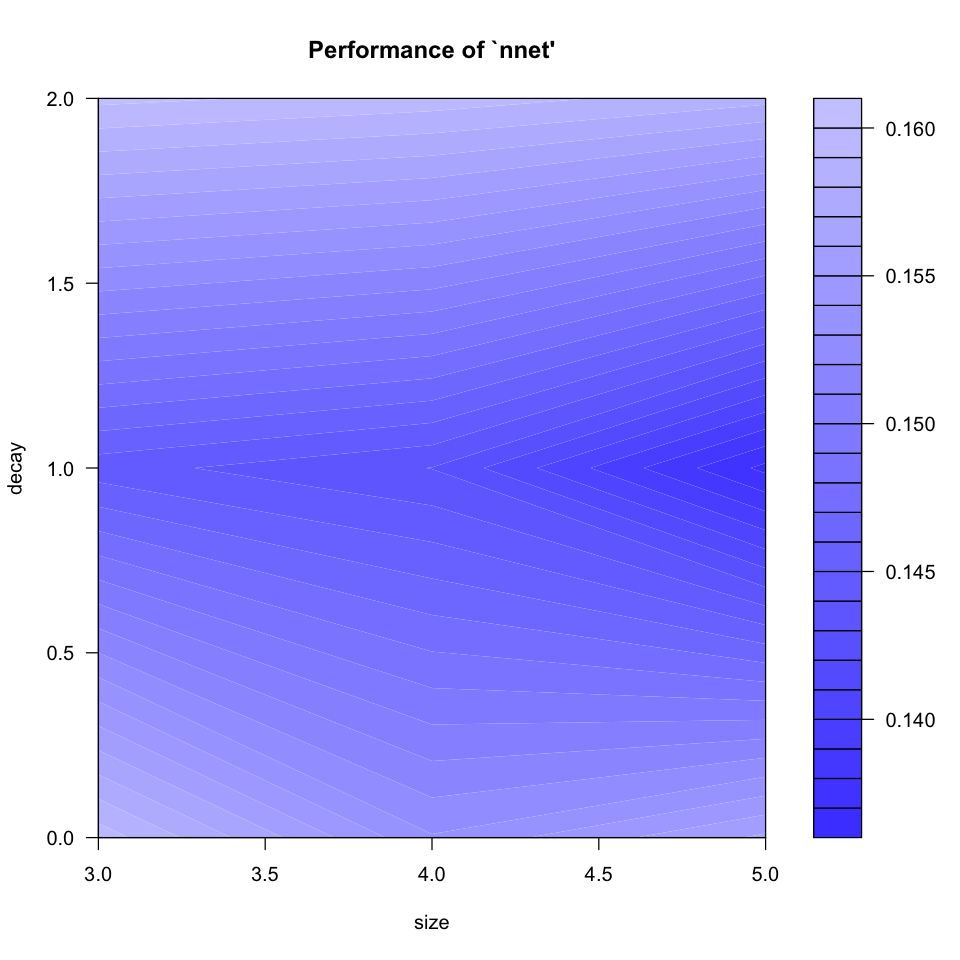

In [ ]:
plot(tune.nnet(DepSeuil~.,data=datappq,size=c(3,4,5),decay=c(0,1,2),maxit=200,linout=FALSE))

In [ ]:
nnet.dis=nnet(DepSeuil~.,data=datappq,size=5,decay=1) 

# weights:  71
initial  value 687.576623 
iter  10 value 341.460558
iter  20 value 308.504592
iter  30 value 290.793141
iter  40 value 290.023618
iter  50 value 287.126112
iter  60 value 277.452725
iter  70 value 272.306582
iter  80 value 268.904289
iter  90 value 266.225449
iter 100 value 265.702747
final  value 265.702747 
stopped after 100 iterations


### Prévisions de l'échantillon test

Différentes prévisions sont considérées assorties des erreurs estimées sur l'échantillon test. Prévision quantitative de la concentration, prévision de dépassement à partir de la prévision quantitative et directement la prévision de dépassement à partir de l'arbre de décision. 

In [ ]:
# Calcul des prévisions
pred.nnetr=predict(nnet.reg,newdata=datestr)
pred.nnetq=predict(nnet.dis,newdata=datestq) 
# Erreur quadratique moyenne de prévision
sum((pred.nnetr-datestr[,"O3obs"])^2)/nrow(datestr)

[1] 653.9853

In [ ]:
# Matrice de confusion pour la prévision du 
# dépassement de seuil (régression)
table(pred.nnetr>150,datestr[,"O3obs"]>150)

       
        FALSE TRUE
  FALSE   156   24
  TRUE      9   20

In [ ]:
# Même chose pour la discrimination
table(pred.nnetq>0.5,datestq[,"DepSeuil"])

       
        FALSE TRUE
  FALSE   163   33
  TRUE      2   11

### Courbes ROC

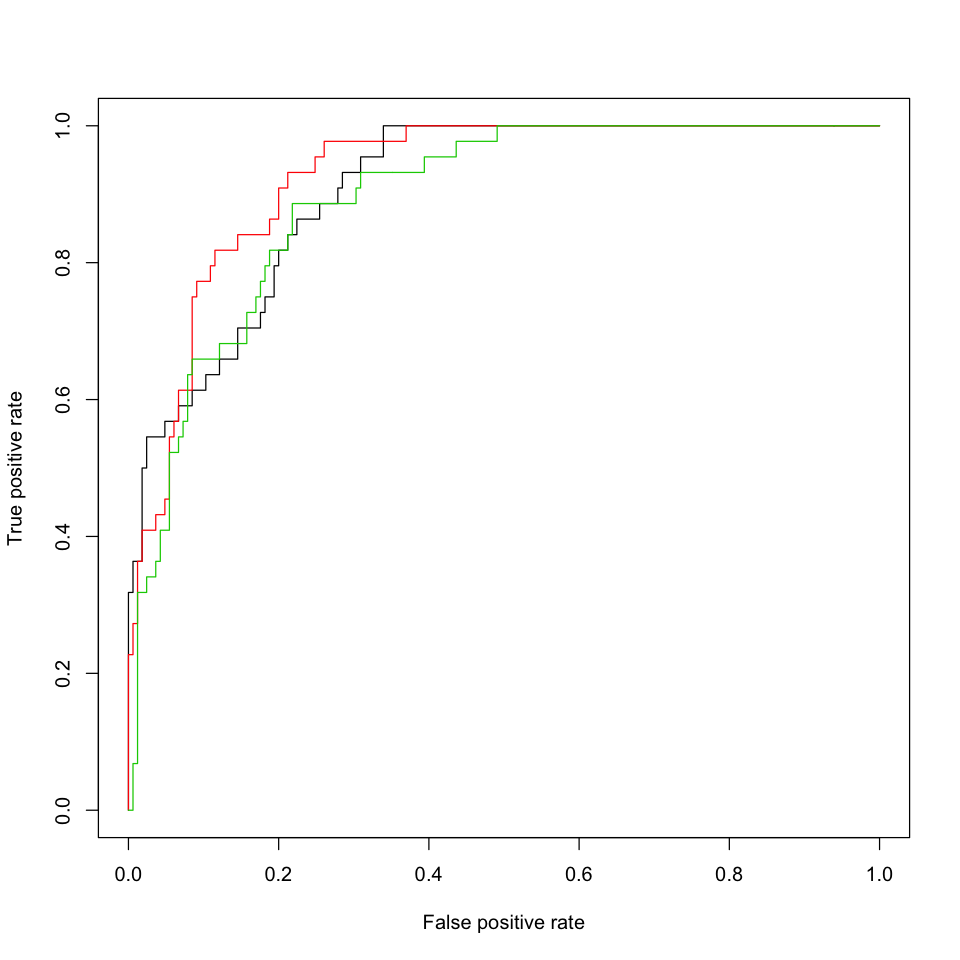

In [ ]:
rocnnetr=pred.nnetr/300
prednnetr=prediction(rocnnetr,datestq$DepSeuil)
perfnnetr=performance(prednnetr,"tpr","fpr")
rocnnetq=pred.nnetq
prednnetq=prediction(rocnnetq,datestq$DepSeuil)
perfnnetq=performance(prednnetq,"tpr","fpr")
# tracer les courbes ROC en les superposant pour mieux comparer
plot(perflogit,col=1)
plot(perfnnetr,col=2,add=TRUE) 
plot(perfnnetq,col=3,add=TRUE)  

**Q** Une méthode semble-t-elle significativement meilleure?

<font color="blue">
A partir des courbes ROC estimées sur l'échantillon test, on remarque que le pic d'ozone est mieux prédit par le réseau de neurone modélisant la concentration par rapport à la prévision directe du dépassement (sa courbe ROC est presque "toujours" au-dessus des deux autres méthodes). Cependant, la performance du réseau de neurone n'est pas significativement meilleure que celle des autres modèles testés précedemment.</font>

***


# Conclusion générale du cours 

Les cours sont axés sur l'utilisation du langage R pour les statistiques et l'analyse des distributions statistiques. La question que je me suis posé est pourquoi le langage R et pas un autre langage, à l'exemple de Python qui est le langage le plus utilisé en Data science.

Dans la Data science, l'objectif est d'analyser les données et leurs donner du sens. Pour ce faire, il faut disposer des outils qui permettent de transformer et d'analyser les données brutes efficacement et rapidement.

L'utilisation du langage R dans les TPs et le projet et la réalisation de quelques recherches m'a permet de trouver la réponse à ma question. J'ai compris pourquoi c'est le choix d'un bon nombre d'informaticiens dans la conception de modèles statistiques pour résoudre des problèmes complexes. En effet, il existe énormément de packages en R qui visent toutes les disciplines des use cases en Data Science (Finance, astronomie, biologie, etc). Il est aussi riche en fonctions qui permettent d'effectuer des modélisations statistiques complexes et des visualisations. Il fournit également un support pour la réalistion d'opérations sur les tableaux, les matrices et les vecteurs. R dispose de packages spécialisés pour la création de grandes varietés de graphiques avec une spécificité de permettre la délimitation de graphiques esthétiques et de les rendre intuitifs pour les utilisateurs qui détectent facilement le concept statistiques à éxploiter. De plus, R est plus flexible pour l’exploration de données et plus rapide dans l'analyse que Python.

L'ensemble des TPs réalisés m'ont appris la programmation en R (Création de dataframes et des colomnes, la manipulation et la visualisation des données).

Le TP1 montre que lorsque l'on est confronté à un cas d'usage en  Data science, la première étape est de procéder à une analyse statistique descriptive unidimensionelle des données. Il s'agit principalement de calculer les effectifs, la fréquence, la moyenne, médiane, quartiles, variances etc. Et de réaliser des représentations graphiques, des diagrammes (de frequence ou effectifs cumulés par exemple) pour visualiser la répartition des données.
Cette étape permet de mieux comprendre l'objectif liée à la problématique et éventuellement anticiper un traitement des données.

Les autres TPs et le projet m'ont appris: 

- L'analyse des corrélations entre variables. Il est important de noter que si deux variables sont très corrélées, alors c'est qu'elles apportent des informations similaires. Ainsi, il y aurait de la redondance durant l'apprentissage du modèle.

- L'application du modèle PCA, qui réduit la dimension des variables. Ce modèle est très utile lorsqu'il y a de nombreuses variables dont la compréhension de la nature peut être complexe. Après application de PCA, il est possible de visualiser les corrélations à l'aide d'une repésentation par vecteurs ou bien une repésentation de la dispersion des points. 

- La division des données aleatoirement en échantillons test et d'apprentissage en gardant une distirbution des données similaires (stratification).

- l'utilisation des modèles de régréssion linaire (avec penalisation L1/Lasso), découvrir l'importance des variables dans la prédiction, choisir les paramètres de régularisation par validation croisée.

- l'utilisation d'un modèle de prévision binomiale et comparer avec d'autres modèles (lineaires, quadratiques)

- l'application d'un modèle de régréssion logisitque, trouver les bon paramètres, utiliser la comparaison avec la courbe ROC

- la partie sur les arbres binaires m'a appris à appliquer un arbre de décision binaire, changer les paramètres (gini, entropie), comprendre le résultat des changements de paramètres ainsi que comment les intérpréter. De plus commprendre pourquoi élaguer un arbre ce que cela signifie (calcul optimaux, rapidité, meilleure visualisation)

- la dernière partie sur les réseau de neurones m'a appris comment implémenter et utiliser les réseaux de neurones en R sur mes données, les différents fonctions de transfert et quand les utiliser, le compromis entre variance et bias, la recherche de compromis entre compléxité (nombre de couches) et résultat voulue et comment les comparer avec les courbes ROC.

   

**-  Durant ce travail, j'ai pu observer l'importance de l'analyse des distributions statistiques des variables avant l'application des modèles, afin de mieux comprendre les données. Aussi, j'ai appris qu'il ne faut pas se limiter à un seul modèle pour répondre à une problématique : chaque cas d'usage est unique donc il est préférable de tester un maximum d'approches pour créer une approche hybride répondant au mieux aux besoins.**


***